In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import geopy
from geopy.distance import geodesic
import os
import pickle


from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
import os


In [145]:
# Define which dataset to use
use_test_data = True  # Set to True when using fraudtest.csv

# Determine dataset type based on the variable
dataset_type = 'Test' if use_test_data else 'Train'



In [146]:
# Directory to save the figures 

input_src_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/data/raw'
output_dir_figures_train = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/figures/train_figures'
output_dir_figures_test = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/figures/test_figures'

In [147]:
# Load the appropriate dataset

if use_test_data:
    output_dir_figures = output_dir_figures_test
else:
    output_dir_figures = output_dir_figures_train
    

In [148]:
# Load the appropriate dataset

if use_test_data:
    df = pd.read_csv(f"{input_src_dir}/fraudTest.csv")  # Concatenate the directory with the filename
else:
    df = pd.read_csv(f"{input_src_dir}/fraudTrain.csv")


In [149]:
print(df.columns)
print(df.shape)


Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
(555719, 23)


In [150]:
df.columns = df.columns.str.strip()


In [151]:
df = df.rename(columns={'amt': 'TransactionAmount', 'cc_num': 'CreditCardNumber', 'dob': 'DateOfBirth', 'trans_date_trans_time': 'TransactionTime'})


In [152]:
print(df.columns)


Index(['Unnamed: 0', 'TransactionTime', 'CreditCardNumber', 'merchant',
       'category', 'TransactionAmount', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [153]:
# Generate a unique TransactionID for each row
df['TransactionID'] = range(1, len(df) + 1)


In [154]:
# Drop the 'Unnamed: 0' column
#df = df.drop(columns=['Unnamed: 0'])

# Verify it's gone
print(df.head())

   Unnamed: 0      TransactionTime  CreditCardNumber  \
0           0  2020-06-21 12:14:25  2291163933867244   
1           1  2020-06-21 12:14:33  3573030041201292   
2           2  2020-06-21 12:14:53  3598215285024754   
3           3  2020-06-21 12:15:15  3591919803438423   
4           4  2020-06-21 12:15:17  3526826139003047   

                               merchant        category  TransactionAmount  \
0                 fraud_Kirlin and Sons   personal_care               2.86   
1                  fraud_Sporer-Keebler   personal_care              29.84   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness              41.28   
3                     fraud_Haley Group        misc_pos              60.05   
4                 fraud_Johnston-Casper          travel               3.19   

    first      last gender                       street  ...      long  \
0    Jeff   Elliott      M            351 Darlene Green  ...  -80.9355   
1  Joanne  Williams      F             3638 Ma

In [155]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# no missing values

Missing values per column:
 Unnamed: 0           0
TransactionTime      0
CreditCardNumber     0
merchant             0
category             0
TransactionAmount    0
first                0
last                 0
gender               0
street               0
city                 0
state                0
zip                  0
lat                  0
long                 0
city_pop             0
job                  0
DateOfBirth          0
trans_num            0
unix_time            0
merch_lat            0
merch_long           0
is_fraud             0
TransactionID        0
dtype: int64


In [156]:
# Count of fraud and non-fraud transactions
fraud_counts = df['is_fraud'].value_counts()
print(fraud_counts)

# Optionally, you can get it in percentage terms
fraud_percentage = df['is_fraud'].value_counts(normalize=True) * 100
print(fraud_percentage)


is_fraud
0    553574
1      2145
Name: count, dtype: int64
is_fraud
0    99.614014
1     0.385986
Name: proportion, dtype: float64


In [157]:
#how many unique credit cards in the data set ??
df['CreditCardNumber'].nunique()

924

In [158]:
print(df.columns)

Index(['Unnamed: 0', 'TransactionTime', 'CreditCardNumber', 'merchant',
       'category', 'TransactionAmount', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID'],
      dtype='object')


In [159]:
# Convert TransactionTime to datetime
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'])

# Optional: Convert DateOfBirth to datetime, if needed
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], errors='coerce')

In [160]:
# Set 'TransactionTime' as the index permanently
df.set_index('TransactionTime', inplace=True)

# Verify the index
print(df.index)


DatetimeIndex(['2020-06-21 12:14:25', '2020-06-21 12:14:33',
               '2020-06-21 12:14:53', '2020-06-21 12:15:15',
               '2020-06-21 12:15:17', '2020-06-21 12:15:37',
               '2020-06-21 12:15:44', '2020-06-21 12:15:50',
               '2020-06-21 12:16:10', '2020-06-21 12:16:11',
               ...
               '2020-12-31 23:57:18', '2020-12-31 23:57:50',
               '2020-12-31 23:57:56', '2020-12-31 23:58:04',
               '2020-12-31 23:58:34', '2020-12-31 23:59:07',
               '2020-12-31 23:59:09', '2020-12-31 23:59:15',
               '2020-12-31 23:59:24', '2020-12-31 23:59:34'],
              dtype='datetime64[ns]', name='TransactionTime', length=555719, freq=None)


In [161]:
# Get the minimum and maximum transaction times from the index
min_time = df.index.min()
max_time = df.index.max()

print(f"Minimum Transaction Time: {min_time}")
print(f"Maximum Transaction Time: {max_time}")


Minimum Transaction Time: 2020-06-21 12:14:25
Maximum Transaction Time: 2020-12-31 23:59:34


In [162]:
df.head()

,Unnamed: 0,CreditCardNumber,merchant,category,TransactionAmount,first,last,gender,street,city,...,long,city_pop,job,DateOfBirth,trans_num,unix_time,merch_lat,merch_long,is_fraud,TransactionID
TransactionTime,,,,,,,,,,,,,,,,,,,,,
2020-06-21 12:14:25,0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,1
2020-06-21 12:14:33,1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,2
2020-06-21 12:14:53,2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,3
2020-06-21 12:15:15,3,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,4
2020-06-21 12:15:17,4,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,5


# Feature Engineering

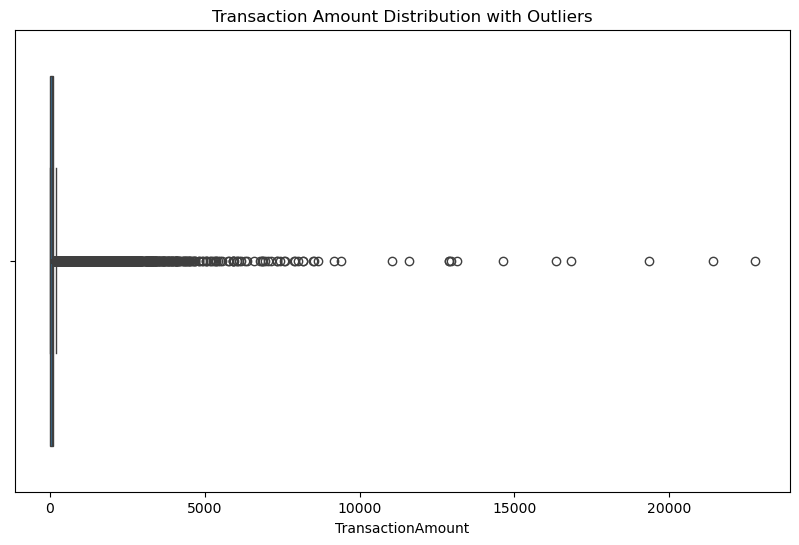

In [163]:
# Handling potential outliers: Visualize TransactionAmount to detect extreme values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(x=df['TransactionAmount'])

# Define the title
title = 'Transaction Amount Distribution with Outliers'
plt.title(title)


# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')


plt.show()

# Clip outliers if necessary
df['TransactionAmount'] = df['TransactionAmount'].clip(upper=df['TransactionAmount'].quantile(0.99))



/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/381701084.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TransactionAmount'].replace([np.inf, -np.inf], np.nan, inplace=True)


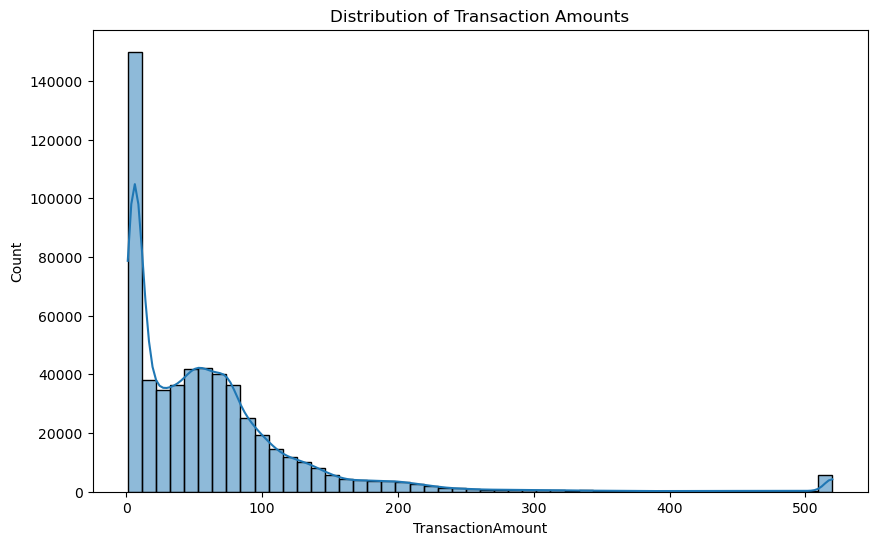

In [164]:

# Replace inf values with NaN (in case they exist in the 'TransactionAmount' column)
df['TransactionAmount'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Distribution of transaction amounts
plt.figure(figsize=(10,6))
sns.histplot(df['TransactionAmount'], bins=50, kde=True)

# Define the title
title = 'Distribution of Transaction Amounts'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')

plt.show()


#Large Number of Low-Value Transactions:
#Observation: The spike on the y-axis at lower transaction amounts (0–100) suggests that the majority of transactions are small, likely everyday purchases.
#Action: This is a common pattern in financial transactions, but it’s worth investigating whether fraud is more frequent in these low-value transactions. You can later break down the fraud vs. non-fraud transactions within this range.
    




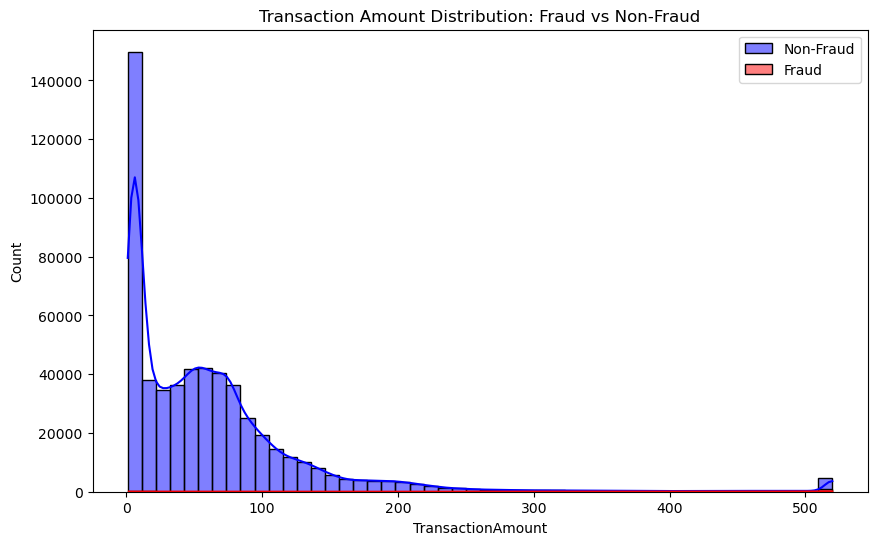

In [165]:
# Distribution of Transaction Amounts by FraudFlag
plt.figure(figsize=(10,6))
sns.histplot(df[df['is_fraud'] == 0]['TransactionAmount'], bins=50, color='blue', kde=True, label='Non-Fraud')
sns.histplot(df[df['is_fraud'] == 1]['TransactionAmount'], bins=50, color='red', kde=True, label='Fraud')

plt.legend()
# Define the title
title = 'Transaction Amount Distribution: Fraud vs Non-Fraud'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')

plt.show()


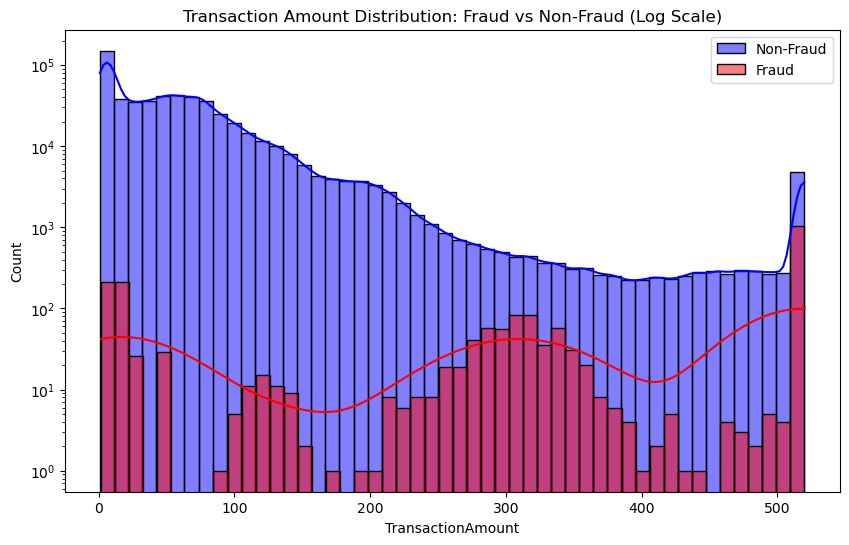

In [166]:
# Re-plot with log scale for better visibility
plt.figure(figsize=(10,6))
sns.histplot(df[df['is_fraud'] == 0]['TransactionAmount'], bins=50, color='blue', kde=True, label='Non-Fraud')
sns.histplot(df[df['is_fraud'] == 1]['TransactionAmount'], bins=50, color='red', kde=True, label='Fraud')
plt.yscale('log')  # Apply log scale to the y-axis
plt.legend()

# Define the title
title = 'Transaction Amount Distribution: Fraud vs Non-Fraud (Log Scale)'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')

plt.show()


# next type of VIZ via transaction id vs transaction count


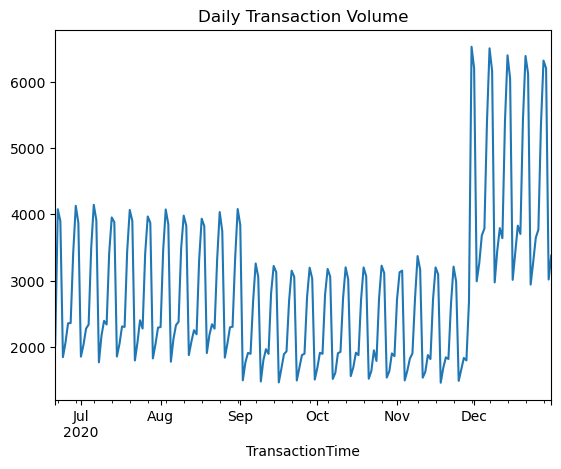

In [167]:
# Now, you can resample and plot without setting the index again
df['TransactionID'].resample('D').count().plot(title='Daily Transaction Volume')


# Define the title
title = 'Daily Transaction Volume'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')

plt.show()

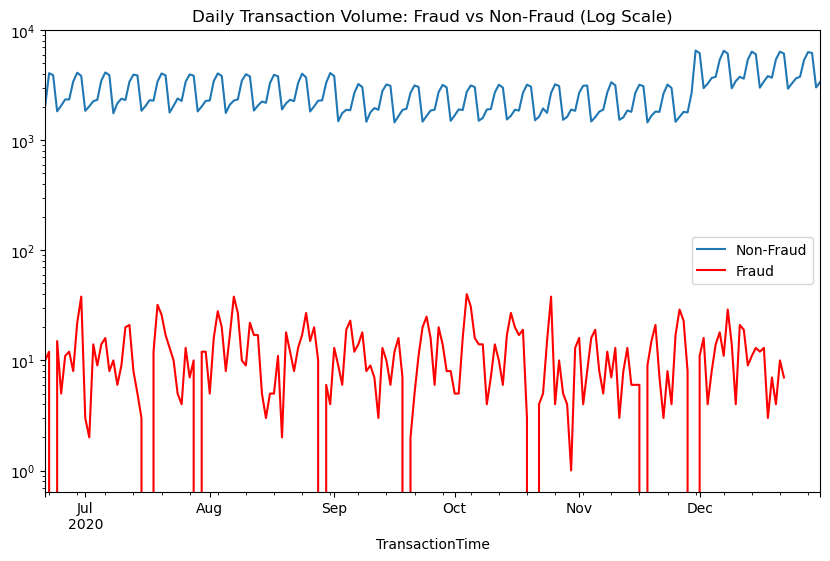

In [168]:

# Plot fraud vs non-fraud over time with a log scale
df[df['is_fraud'] == 0].resample('D')['TransactionID'].count().plot(label='Non-Fraud', figsize=(10,6))
df[df['is_fraud'] == 1].resample('D')['TransactionID'].count().plot(label='Fraud', figsize=(10,6), color='red')
plt.yscale('log')  # Apply log scale to y-axis
plt.legend()

# Define the title
title = 'Daily Transaction Volume: Fraud vs Non-Fraud (Log Scale)'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')


plt.show()

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/1388463641.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['is_fraud'] == 0].resample('H')['TransactionID'].count().plot(label='Non-Fraud', figsize=(10,6), color='blue')  # Non-Fraud
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/1388463641.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['is_fraud'] == 1].resample('H')['TransactionID'].count().plot(label='Fraud', figsize=(10,6), color='red')  # Fraud


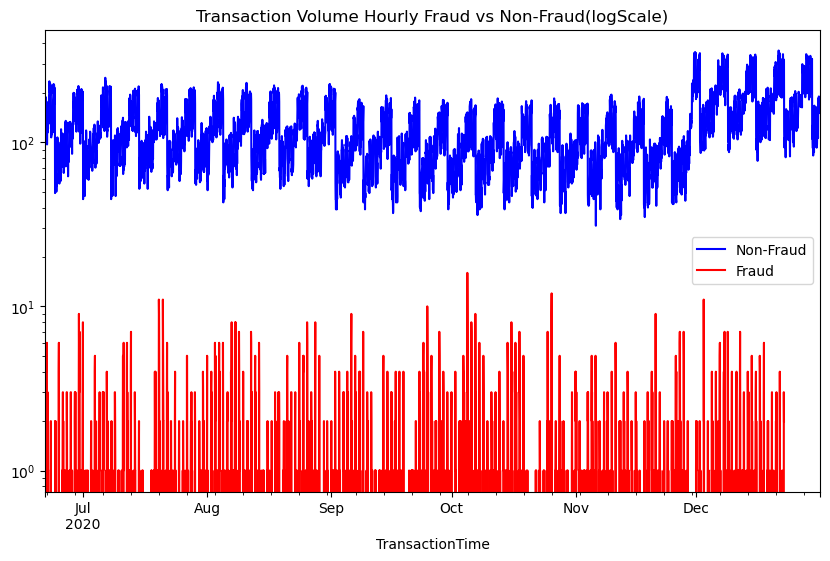

In [169]:
# Resample by hour ('H') to get hourly non-fraud and fraud transaction counts
df[df['is_fraud'] == 0].resample('H')['TransactionID'].count().plot(label='Non-Fraud', figsize=(10,6), color='blue')  # Non-Fraud
df[df['is_fraud'] == 1].resample('H')['TransactionID'].count().plot(label='Fraud', figsize=(10,6), color='red')  # Fraud

plt.yscale('log')  # Apply log scale to y-axis
plt.legend()

# Define the title
title = 'Transaction Volume Hourly Fraud vs Non-Fraud(logScale)'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')

plt.show()


In [170]:
# Extract hour from TransactionTime
df['Hour'] = df.index.hour  # Since TransactionTime is already set as the index


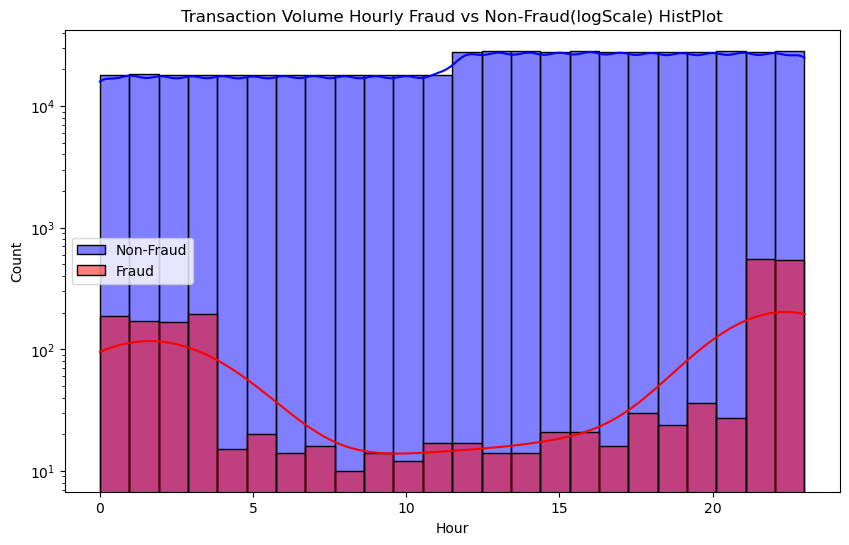

In [171]:
# Plot hourly distribution of fraud vs non-fraud transactions
plt.figure(figsize=(10,6))
sns.histplot(df[df['is_fraud'] == 0]['Hour'], bins=24, color='blue', kde=True, label='Non-Fraud')
sns.histplot(df[df['is_fraud'] == 1]['Hour'], bins=24, color='red', kde=True, label='Fraud')

plt.yscale('log')  # Apply log scale to y-axis
plt.legend()

# Define the title
title = 'Transaction Volume Hourly Fraud vs Non-Fraud(logScale) HistPlot'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')

plt.show()


In [172]:
# Calculate fraud rate by hour
fraud_rate_by_hour = df.groupby('Hour')['is_fraud'].mean()

# Sort by fraud rate in descending order
fraud_rate_by_hour = fraud_rate_by_hour.sort_values(ascending=False)

# Define a threshold for high-risk hours (adjust as needed)
threshold = fraud_rate_by_hour.mean()  # Mean fraud rate across all hours

# Dynamically identify high-risk hours based on the threshold
high_risk_hours = fraud_rate_by_hour[fraud_rate_by_hour > threshold].index.tolist()

# Print high-risk hours for reference
print("High-Risk Hours:", high_risk_hours)

# Create the HighRiskHour flag based on dynamically identified high-risk hours
df['HighRiskHour'] = df['Hour'].apply(lambda x: 1 if x in high_risk_hours else 0)

# Print a sample of the DataFrame to verify the new column
print(df[['Hour', 'HighRiskHour']])


High-Risk Hours: [22, 23, 3, 0, 2, 1]
                     Hour  HighRiskHour
TransactionTime                        
2020-06-21 12:14:25    12             0
2020-06-21 12:14:33    12             0
2020-06-21 12:14:53    12             0
2020-06-21 12:15:15    12             0
2020-06-21 12:15:17    12             0
...                   ...           ...
2020-12-31 23:59:07    23             1
2020-12-31 23:59:09    23             1
2020-12-31 23:59:15    23             1
2020-12-31 23:59:24    23             1
2020-12-31 23:59:34    23             1

[555719 rows x 2 columns]


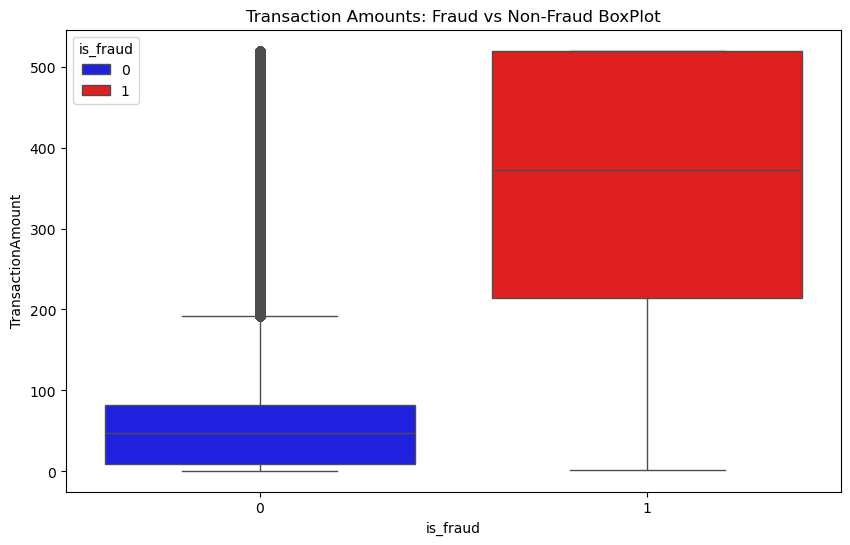

In [173]:
plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='TransactionAmount', hue='is_fraud', palette={0: 'blue', 1: 'red'}, data=df)


# Define the title
title = 'Transaction Amounts: Fraud vs Non-Fraud BoxPlot'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

# Further analysis on data

1. Time-Based Analysis:
Already explored daily and hourly trends in transaction volumes, but now dive deeper into fraud patterns based on time.



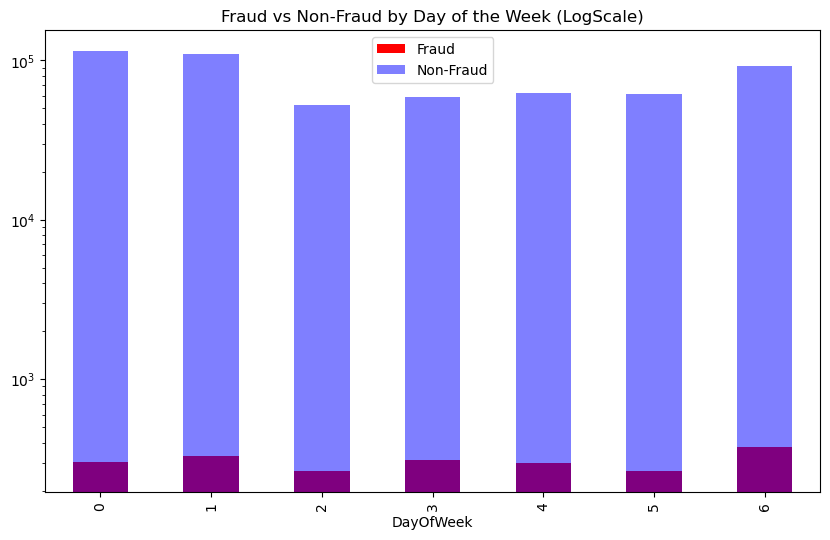

In [174]:
#Weekday vs. Weekend: Is fraud more common on weekdays or weekends?
df['DayOfWeek'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
fraud_by_day = df[df['is_fraud'] == 1]['DayOfWeek'].value_counts().sort_index()
non_fraud_by_day = df[df['is_fraud'] == 0]['DayOfWeek'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10,6))
fraud_by_day.plot(kind='bar', label='Fraud', color='red')
non_fraud_by_day.plot(kind='bar', label='Non-Fraud', color='blue', alpha=0.5)
plt.yscale('log')  # Apply log scale to y-axis
plt.legend()

# Define the title
title = 'Fraud vs Non-Fraud by Day of the Week (LogScale)'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()


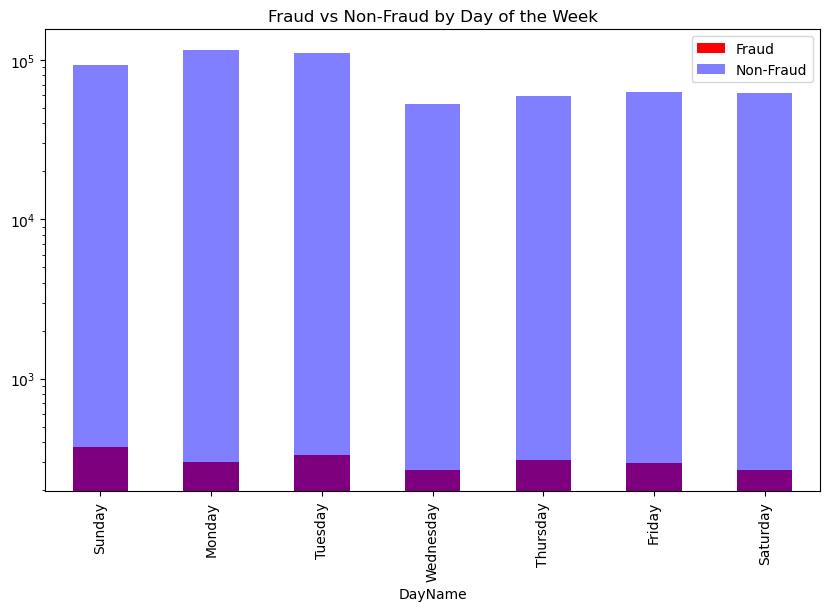

In [175]:

# Define the correct day order
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


df['DayName'] = df.index.day_name()
# Convert the 'DayName' column to a categorical type with the correct order
df['DayName'] = pd.Categorical(df['DayName'], categories=day_order, ordered=True)

fraud_by_day = df[df['is_fraud'] == 1]['DayName'].value_counts().sort_index()
non_fraud_by_day = df[df['is_fraud'] == 0]['DayName'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10,6))
fraud_by_day.plot(kind='bar', label='Fraud', color='red')
non_fraud_by_day.plot(kind='bar', label='Non-Fraud', color='blue', alpha=0.5)
plt.title('Fraud vs Non-Fraud by Day of the Week')

plt.yscale('log')  # Apply log scale to y-axis
plt.legend()
plt.show()

In [176]:
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
weekend_fraud = df[df['is_fraud'] == 1]['IsWeekend'].mean()
weekend_non_fraud = df[df['is_fraud'] == 0]['IsWeekend'].mean()

print(f"Percentage of fraud on weekends: {weekend_fraud * 100:.2f}%")
print(f"Percentage of non-fraud on weekends: {weekend_non_fraud * 100:.2f}%")


Percentage of fraud on weekends: 29.84%
Percentage of non-fraud on weekends: 27.95%


In [177]:
#location based analysis

In [178]:
# Calculate distance between cardholder and merchant
df['distance'] = df.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km, axis=1)


In [179]:
# Check unique values in the 'is_fraud' column
df['is_fraud'].unique()


array([0, 1])

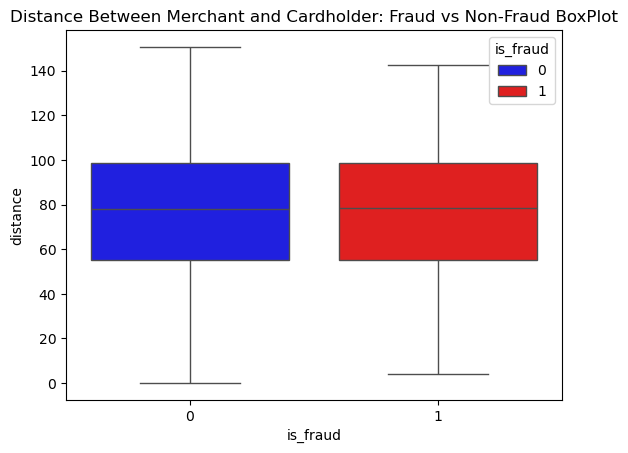

In [180]:
sns.boxplot(x='is_fraud', y='distance', data=df, hue='is_fraud', palette={0: 'blue', 1: 'red'})

# Define the title
title = 'Distance Between Merchant and Cardholder: Fraud vs Non-Fraud BoxPlot'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()



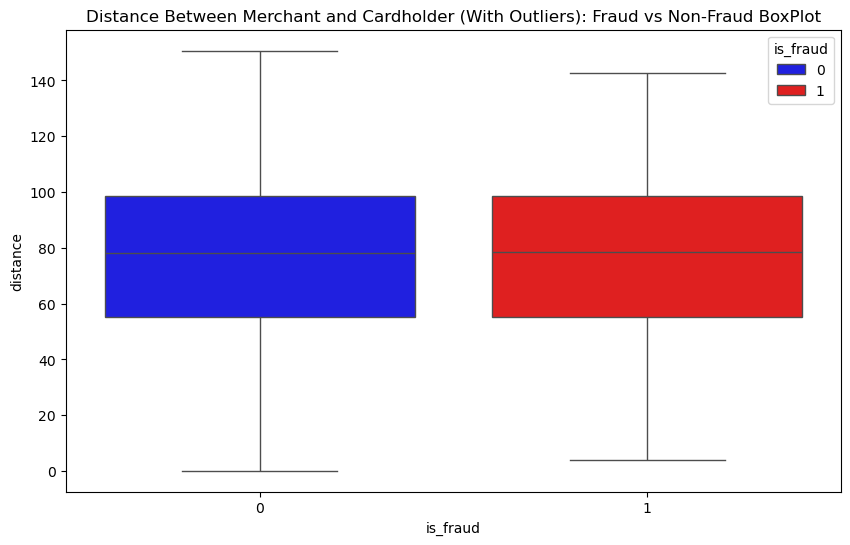

In [181]:
plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='distance', data=df, hue='is_fraud', palette={0: 'blue', 1: 'red'}, showfliers=True)

# Define the title
title = 'Distance Between Merchant and Cardholder (With Outliers): Fraud vs Non-Fraud BoxPlot'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()


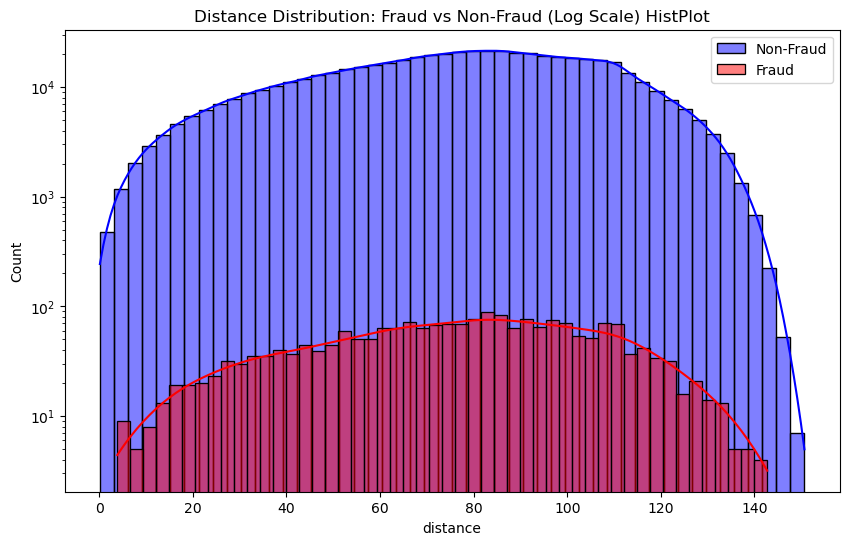

In [182]:
# Plot histograms for distance comparison with log scale
plt.figure(figsize=(10,6))
sns.histplot(df[df['is_fraud'] == 0]['distance'], bins=50, color='blue', kde=True, label='Non-Fraud')
sns.histplot(df[df['is_fraud'] == 1]['distance'], bins=50, color='red', kde=True, label='Fraud')
plt.yscale('log')  # Apply log scale to y-axis
plt.title('Distance Distribution: Fraud vs Non-Fraud (Log Scale)')
plt.legend()

# Define the title
title = 'Distance Distribution: Fraud vs Non-Fraud (Log Scale) HistPlot'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()



Based on description of the log-scaled histogram:

    Fraud transactions rise up to 10 power 1 on the y-axis (i.e., 10 transactions) and generally stay below 102102 (i.e., 100 transactions).
    Non-fraud transactions dominate the y-axis, exceeding 104104 (i.e., 10,000 transactions).

Interpretation:

    The majority of non-fraud transactions happen across a wide range of distances and in much larger numbers, which is expected given the imbalance.
    Fraudulent transactions, while visible in lower quantities, don’t seem to spike at any particular distance, suggesting that distance alone isn't a strong indicator of fraud.

Next Steps:

Since the log scale still shows no clear separation between fraud and non-fraud based on distance, it confirms that distance is not a useful standalone feature for distinguishing fraud in your dataset.

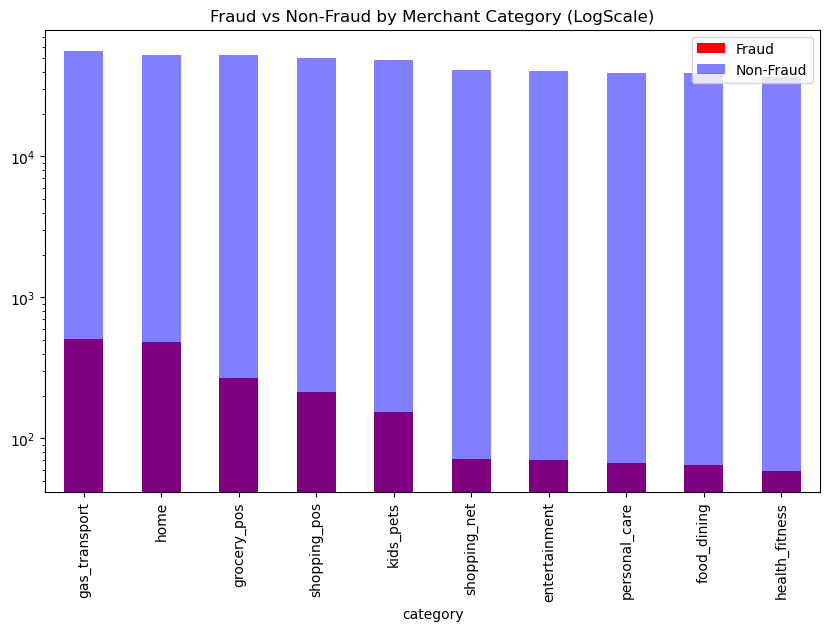

In [183]:
# Fraud vs Non-Fraud by Merchant Category
fraud_by_category = df[df['is_fraud'] == 1]['category'].value_counts().head(10)
non_fraud_by_category = df[df['is_fraud'] == 0]['category'].value_counts().head(10)

# Plot
plt.figure(figsize=(10,6))
fraud_by_category.plot(kind='bar', label='Fraud', color='red')
non_fraud_by_category.plot(kind='bar', label='Non-Fraud', color='blue', alpha=0.5)
plt.yscale('log')  # Apply log scale to y-axis
plt.legend()


# Define the title
title = 'Fraud vs Non-Fraud by Merchant Category (LogScale)'
plt.title(title)

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()




In [184]:
# Top 5 categories with the highest fraud counts
top_fraud_merchant_categories = df[df['is_fraud'] == 1]['category'].value_counts().head(5).index.tolist()

# Print top fraudulent categories
print("Top Fraudulent Merchant Categories:", top_fraud_merchant_categories)

# Create HighRiskMerchantCategory flag
df['HighRiskMerchantCategory'] = df['category'].apply(lambda x: 1 if x in top_fraud_merchant_categories else 0)

# Correctly print the HighRiskMerchantCategory column
#print(df['HighRiskMerchantCategory'])


Top Fraudulent Merchant Categories: ['shopping_net', 'grocery_pos', 'misc_net', 'shopping_pos', 'gas_transport']


In [185]:
# Print the count of 1s and 0s in HighRiskMerchantCategory
print(df['HighRiskMerchantCategory'].value_counts())


HighRiskMerchantCategory
0    327859
1    227860
Name: count, dtype: int64


# Potential Additional Features:
Transaction Frequency:
    Feature: How often a credit card has been used within a specific time frame (e.g., last hour or day).
    Why: Fraudsters often make rapid successive transactions within short periods. You could create a rolling window to calculate transaction frequency.
    Calculate the number of transactions within the past X hours/days using a rolling window on the TransactionTime feature.

#age group

In [186]:
import pandas as pd

# Ensure 'DateOfBirth' is in datetime format
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], errors='coerce')  # Handle errors during conversion

# Step 1: Calculate Age
# Calculate age in years
df['Age'] = (pd.Timestamp.now() - df['DateOfBirth']).dt.days // 365  # Age in years

# Step 2: Create Age Groups
# Define age bins and labels
bins = [0, 18, 25, 35, 45, 55, 65, 100]  # Define your age bins, ensuring to cover all possible ages
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']  # Corresponding labels

# Create age group feature, include NaN values handling
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Verify the new features without truncating DataFrame
#print(df[['DateOfBirth', 'Age', 'AgeGroup']].head(10))  # Display the first 10 entries


In [187]:
def count_transactions_within_last_hour(group):
    # Create an empty list to hold the frequencies
    frequencies = []
    
    # Loop over each transaction time in the group
    for time in group.index:
        # Count the number of transactions within the last hour
        count = group[(group.index >= (time - pd.Timedelta(hours=1))) & (group.index <= time)].shape[0]
        frequencies.append(count)
    
    return frequencies

# Apply the function to each group
df['TransactionFrequency'] = df.groupby('CreditCardNumber').apply(count_transactions_within_last_hour).reset_index(drop=True)
print(df[['TransactionFrequency']].head(10))  # Display the first 10 entries


                    TransactionFrequency
TransactionTime                         
2020-06-21 12:14:25                  NaN
2020-06-21 12:14:33                  NaN
2020-06-21 12:14:53                  NaN
2020-06-21 12:15:15                  NaN
2020-06-21 12:15:17                  NaN
2020-06-21 12:15:37                  NaN
2020-06-21 12:15:44                  NaN
2020-06-21 12:15:50                  NaN
2020-06-21 12:16:10                  NaN
2020-06-21 12:16:11                  NaN


/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/2620616198.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['TransactionFrequency'] = df.groupby('CreditCardNumber').apply(count_transactions_within_last_hour).reset_index(drop=True)


In [188]:
# Resample the data to count transactions every hour
transaction_counts_hourly = df.resample('H').size()
transaction_counts_daily = df.resample('D').size()

# Combine with CreditCardNumber if necessary
transaction_counts = df.groupby('CreditCardNumber').resample('H').size().reset_index(name='TransactionCount')
print(transaction_counts.head(10))

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/1490275857.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  transaction_counts_hourly = df.resample('H').size()
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/1490275857.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  transaction_counts = df.groupby('CreditCardNumber').resample('H').size().reset_index(name='TransactionCount')


   CreditCardNumber     TransactionTime  TransactionCount
0       60416207185 2020-06-21 13:00:00                 1
1       60416207185 2020-06-21 14:00:00                 0
2       60416207185 2020-06-21 15:00:00                 0
3       60416207185 2020-06-21 16:00:00                 1
4       60416207185 2020-06-21 17:00:00                 0
5       60416207185 2020-06-21 18:00:00                 0
6       60416207185 2020-06-21 19:00:00                 0
7       60416207185 2020-06-21 20:00:00                 0
8       60416207185 2020-06-21 21:00:00                 0
9       60416207185 2020-06-21 22:00:00                 0


In [189]:
total_transactions = df.groupby('CreditCardNumber').size().reset_index(name='TotalTransactionCount')
print(total_transactions.head(10))


   CreditCardNumber  TotalTransactionCount
0       60416207185                    678
1       60422928733                    669
2       60423098130                    228
3       60427851591                    215
4       60487002085                    239
5       60490596305                    455
6       60495593109                    224
7      501802953619                    635
8      501828204849                    218
9      501831082224                    439


In [190]:
# Calculate the time difference between consecutive transactions
time_diff = df.index.to_series().diff().dt.total_seconds()
# Flag rapid transactions (within 5 minutes)
df['RapidTransactionFlag'] = time_diff < 60  # For a 1-minute threshold

# Create a temporary DataFrame for rapid transactions
rapid_transactions = df[df['RapidTransactionFlag']]

# Group by date and count the number of rapid transactions
rapid_transaction_counts = rapid_transactions.groupby(rapid_transactions.index.date).size()
print(rapid_transaction_counts)

# Get a summary of the rapid transactions
rapid_transactions_summary = rapid_transactions.describe()
print(rapid_transactions_summary)


2020-06-21    1908
2020-06-22    3834
2020-06-23    3602
2020-06-24    1352
2020-06-25    1578
              ... 
2020-12-27    5183
2020-12-28    6212
2020-12-29    6123
2020-12-30    2630
2020-12-31    3044
Length: 194, dtype: int64
          Unnamed: 0  CreditCardNumber  TransactionAmount            zip  \
count  478827.000000      4.788270e+05      478827.000000  478827.000000   
mean   282352.474282      4.156977e+17          63.671204   48855.657540   
min         1.000000      6.041621e+10           1.000000    1257.000000   
25%    139140.500000      1.800429e+14           9.510000   26292.000000   
50%    283432.000000      3.521417e+15          46.370000   48174.000000   
75%    429493.500000      4.635331e+15          82.260000   72042.000000   
max    555718.000000      4.992346e+18         519.854600   99921.000000   
std    163611.709333      1.306822e+18          78.874224   26858.296762   

                 lat           long      city_pop  \
count  478827.000000  47882

In [191]:
print(df.columns)


Index(['Unnamed: 0', 'CreditCardNumber', 'merchant', 'category',
       'TransactionAmount', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID', 'Hour', 'HighRiskHour', 'DayOfWeek', 'DayName',
       'IsWeekend', 'distance', 'HighRiskMerchantCategory', 'Age', 'AgeGroup',
       'TransactionFrequency', 'RapidTransactionFlag'],
      dtype='object')


Transaction Amount Features:
Log Transaction Amount: Normalize the TransactionAmount by taking its logarithm to reduce skewness.
Transaction Amount Flags: Create binary flags for high-value transactions (e.g., if TransactionAmount exceeds a certain threshold).

In [192]:

# Sample DataFrame creation
# Assume 'df' is your DataFrame and has a 'TransactionAmount' column
# df = pd.read_csv('your_data.csv')  # Load your actual data

# Step 1: Log Transaction Amount
# Calculate the log of TransactionAmount
df['LogTransactionAmount'] = np.log1p(df['TransactionAmount'])  # Use log1p for stability with 0 values

# Step 2: Create Transaction Amount Flags
# Define a threshold for high-value transactions
threshold = 100  # Adjust the threshold based on your data context

# Create a flag for high-value transactions
df['HighValueTransactionFlag'] = df['TransactionAmount'] > threshold

# Verify the new features
print(df[['TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag']].head(10))  # Display the first 10 entries


                     TransactionAmount  LogTransactionAmount  \
TransactionTime                                                
2020-06-21 12:14:25               2.86              1.350667   
2020-06-21 12:14:33              29.84              3.428813   
2020-06-21 12:14:53              41.28              3.744314   
2020-06-21 12:15:15              60.05              4.111693   
2020-06-21 12:15:17               3.19              1.432701   
2020-06-21 12:15:37              19.55              3.022861   
2020-06-21 12:15:44             133.93              4.904756   
2020-06-21 12:15:50              10.37              2.430978   
2020-06-21 12:16:10               4.37              1.680828   
2020-06-21 12:16:11              66.54              4.212720   

                     HighValueTransactionFlag  
TransactionTime                                
2020-06-21 12:14:25                     False  
2020-06-21 12:14:33                     False  
2020-06-21 12:14:53                    

Behavioral Features:
Count of Transactions in Last X Days: Count how many transactions have occurred in the last 7, 14, or 30 days.
Average Transaction Amount in Last X Days: Calculate the average transaction amount over the same periods.

In [193]:
import pandas as pd

# Assuming 'TransactionTime' is already set as the index and in datetime format

# Step 1: Count of Transactions in Last X Days
for days in [7, 14, 30]:
    # Sort data by CreditCardNumber and TransactionTime to ensure rolling works properly
    df = df.sort_values(by=['CreditCardNumber', 'TransactionTime'])
    
    # Apply rolling and count the number of transactions for each card
    df[f'TransactionCountLast{days}Days'] = (
        df.groupby('CreditCardNumber')['CreditCardNumber']
        .rolling(f'{days}D')
        .count()
        .reset_index(level=0, drop=True)
    )

# Step 2: Average Transaction Amount in Last X Days
for days in [7, 14, 30]:
    # Sort data by CreditCardNumber and TransactionTime to ensure rolling works properly
    df = df.sort_values(by=['CreditCardNumber', 'TransactionTime'])
    
    # Calculate the average transaction amount for each credit card in the last X days
    df[f'AverageTransactionAmountLast{days}Days'] = (
        df.groupby('CreditCardNumber')['TransactionAmount']
        .rolling(f'{days}D')
        .mean()
        .reset_index(level=0, drop=True)
    )

# Verify the new features
print(df[['TransactionCountLast7Days', 'TransactionCountLast14Days', 'TransactionCountLast30Days',
           'AverageTransactionAmountLast7Days', 'AverageTransactionAmountLast14Days', 'AverageTransactionAmountLast30Days']].head(10))


                     TransactionCountLast7Days  TransactionCountLast14Days  \
TransactionTime                                                              
2020-06-21 13:05:42                        1.0                         1.0   
2020-06-21 16:25:36                        2.0                         2.0   
2020-06-22 07:58:33                        3.0                         3.0   
2020-06-22 15:32:31                        4.0                         4.0   
2020-06-23 12:28:54                        5.0                         5.0   
2020-06-23 14:24:48                        6.0                         6.0   
2020-06-23 16:39:40                        7.0                         7.0   
2020-06-23 19:07:05                        8.0                         8.0   
2020-06-23 22:45:57                        9.0                         9.0   
2020-06-24 04:22:17                       10.0                        10.0   

                     TransactionCountLast30Days  \
TransactionT

In [194]:
print(df.columns)  # Display all columns in the DataFrame


Index(['Unnamed: 0', 'CreditCardNumber', 'merchant', 'category',
       'TransactionAmount', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID', 'Hour', 'HighRiskHour', 'DayOfWeek', 'DayName',
       'IsWeekend', 'distance', 'HighRiskMerchantCategory', 'Age', 'AgeGroup',
       'TransactionFrequency', 'RapidTransactionFlag', 'LogTransactionAmount',
       'HighValueTransactionFlag', 'TransactionCountLast7Days',
       'TransactionCountLast14Days', 'TransactionCountLast30Days',
       'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days'],
      dtype='object')


# Graph Construction with NetworkX:

Highlight Fraudulent Nodes: Overlay of fraudulent and non-fraudulent credit cards on this degree distribution to see if there’s a difference in their degrees.

Number of unique credit card nodes: 924
Number of unique merchant nodes: 693
Number of credit card nodes with degrees: 924
Number of merchant nodes with degrees: 693


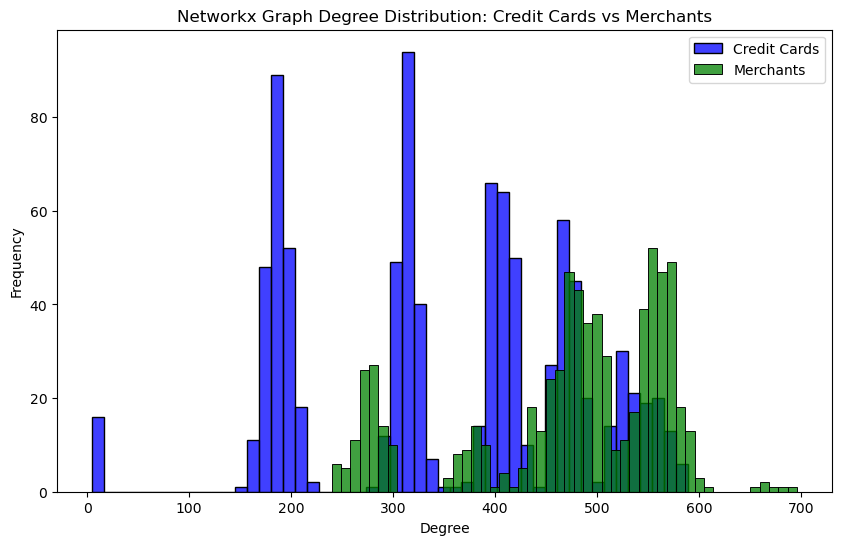

In [195]:


# Create an empty graph
G = nx.Graph()

# Add edges between credit cards and merchants, including transaction amount as an edge attribute
for idx, row in df.iterrows():
    credit_card = str(row['CreditCardNumber'])
    merchant = str(row['merchant'])
    transaction_amount = row['TransactionAmount']  # Ensure TransactionAmount exists in your dataframe
    
    # Add an edge with the transaction amount as an attribute
    G.add_edge(credit_card, merchant, transaction_amount=transaction_amount)


# Calculate degrees for all nodes in the graph
degrees = dict(G.degree())

# Filter degrees for credit cards and merchants
credit_card_nodes = df['CreditCardNumber'].astype(str).unique()
merchant_nodes = df['merchant'].astype(str).unique()

credit_card_degrees = {node: degrees[node] for node in credit_card_nodes if node in degrees}
merchant_degrees = {node: degrees[node] for node in merchant_nodes if node in degrees}

# Debugging: Print counts to ensure correctness
print(f"Number of unique credit card nodes: {len(credit_card_nodes)}")
print(f"Number of unique merchant nodes: {len(merchant_nodes)}")
print(f"Number of credit card nodes with degrees: {len(credit_card_degrees)}")
print(f"Number of merchant nodes with degrees: {len(merchant_degrees)}")

# Create a new DataFrame for easier plotting
degree_df = pd.DataFrame({
    'CreditCardDegree': pd.Series(credit_card_degrees),
    'MerchantDegree': pd.Series(merchant_degrees)
})

# Plot histograms for both credit cards and merchants
plt.figure(figsize=(10,6))

# Plot Credit Card Degrees
sns.histplot(degree_df['CreditCardDegree'].dropna(), bins=50, color='blue', label='Credit Cards')

# Plot Merchant Degrees
sns.histplot(degree_df['MerchantDegree'].dropna(), bins=50, color='green', label='Merchants')



# Define the title
title = 'Networkx Graph Degree Distribution: Credit Cards vs Merchants'
plt.title(title)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()


In [196]:
# Add degree information back to the original DataFrame
df['degree'] = df['CreditCardNumber'].astype(str).map(credit_card_degrees)



In [197]:
# Check edges and their attributes
#for edge in G.edges(data=True):
#    print(edge)

#do NOT print this, huge list


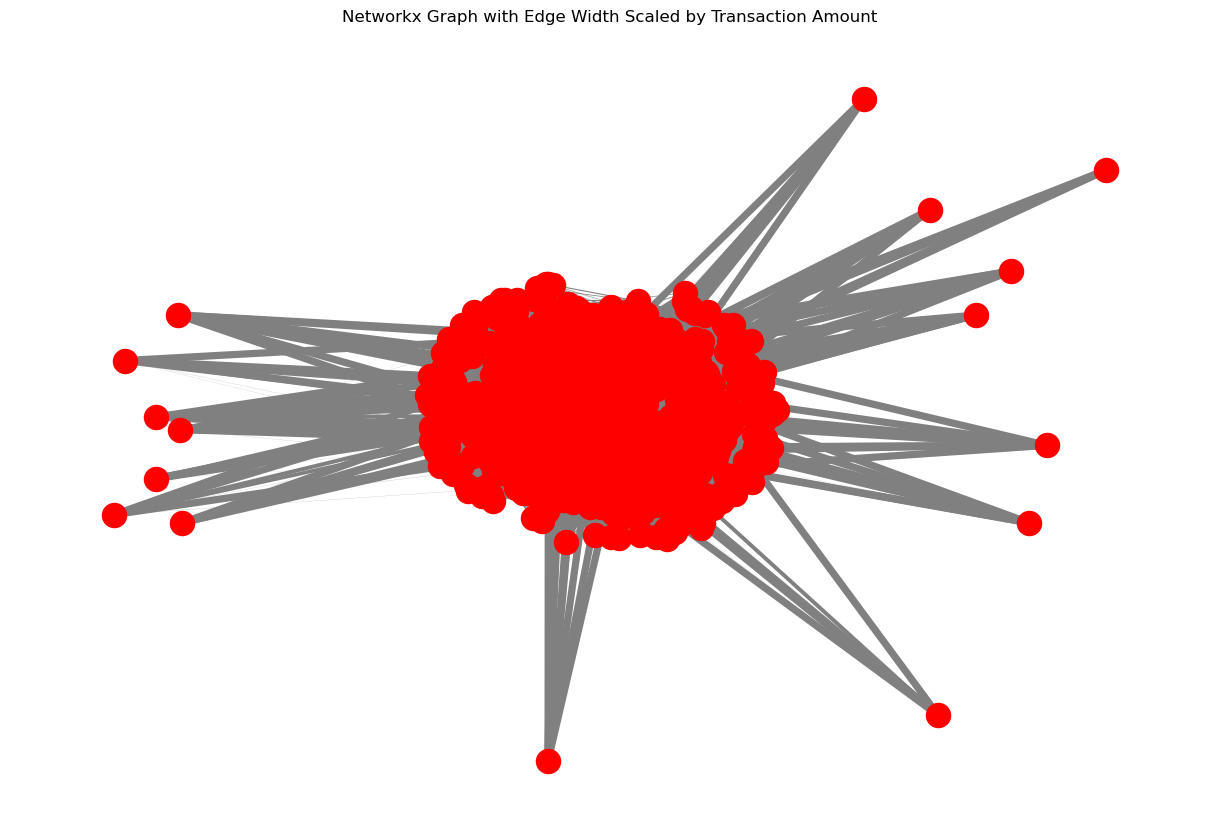

In [198]:
# Scale edge width by transaction amount
edge_width = [G.edges[edge]['transaction_amount'] / 100 for edge in G.edges()]

# Visualize the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=300, width=edge_width, node_color='red', edge_color='gray')


# Define the title
title = 'Networkx Graph with Edge Width Scaled by Transaction Amount'
plt.title(title)


# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

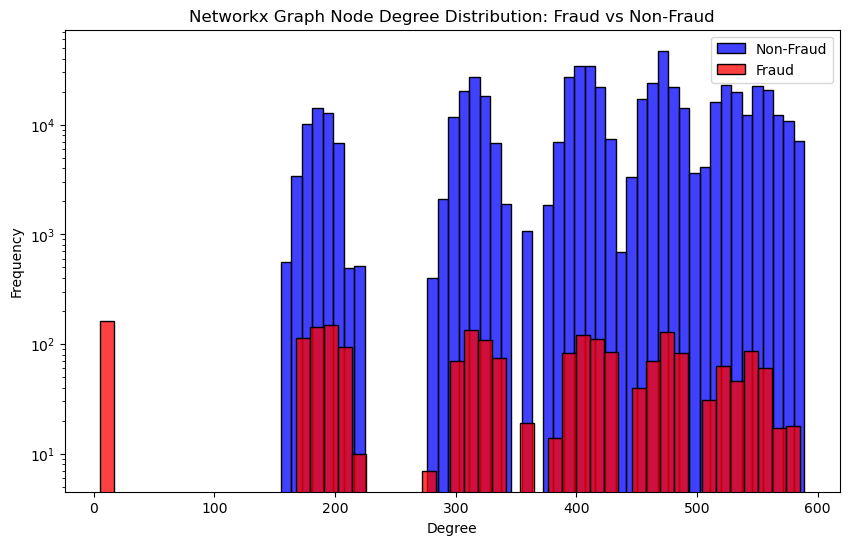

In [199]:
# Plot Degree Distribution: Fraud vs Non-Fraud
plt.figure(figsize=(10,6))

# Non-Fraud Distribution
sns.histplot(df[df['is_fraud'] == 0]['degree'].dropna(), bins=50, color='blue', label='Non-Fraud')

# Fraud Distribution
sns.histplot(df[df['is_fraud'] == 1]['degree'].dropna(), bins=50, color='red', label='Fraud')



# Define the title
title = 'Networkx Graph Node Degree Distribution: Fraud vs Non-Fraud'
plt.title(title)
plt.yscale('log')  # Apply log scale to the y-axis
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

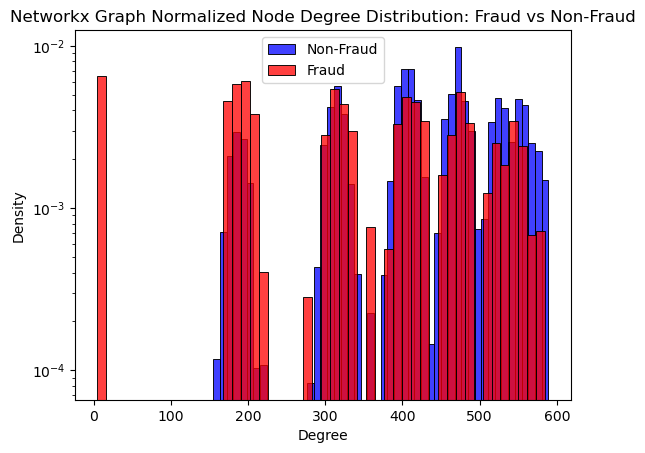

In [200]:
#Use a Relative Count (Normalize the Histogram):
sns.histplot(df[df['is_fraud'] == 0]['degree'], bins=50, color='blue', label='Non-Fraud', stat='density')
sns.histplot(df[df['is_fraud'] == 1]['degree'], bins=50, color='red', label='Fraud', stat='density')


# Define the title
title = 'Networkx Graph Normalized Node Degree Distribution: Fraud vs Non-Fraud'
plt.title(title)
plt.yscale('log')  # Apply log scale to the y-axis
plt.xlabel('Degree')
plt.ylabel('Density')
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

By Obserbving cumulative distribution plot, it shows the fraud and non-fraud nodes have similar degree ranges (both from 180 to 600 on the x-axis), but the counts differ significantly (with non-fraud counts reaching up to 106106 while fraud only reaches up to 102102). This confirms that fraud cases are rare and generally obscured by the large number of non-fraud cases.

    Fraud and non-fraud nodes have similar degree ranges, meaning the degree itself may not be a strong indicator of fraud when considered alone.
    Non-fraud nodes dominate the network in terms of volume, which is expected due to the class imbalance.
    The logarithmic scale is helpful here to show the difference in distribution between fraud and non-fraud.

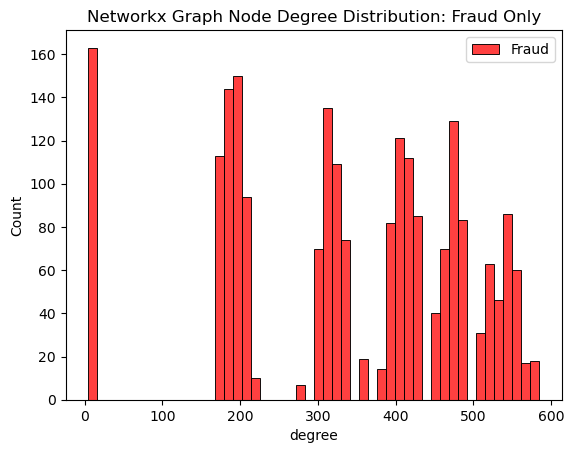

In [201]:
# 4. Highlight Fraud Nodes on a Separate Plot:
sns.histplot(df[df['is_fraud'] == 1]['degree'], bins=50, color='red', label='Fraud')


# Define the title
title = 'Networkx Graph Node Degree Distribution: Fraud Only'
plt.title(title)
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

In [202]:
df['CreditCardNumber'] = df['CreditCardNumber'].astype(str)


In [203]:
fraud_mapping = df.set_index('CreditCardNumber')['is_fraud'].to_dict()


In [204]:
#print(fraud_mapping.head(5))
#only testing purposes

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/3900588920.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


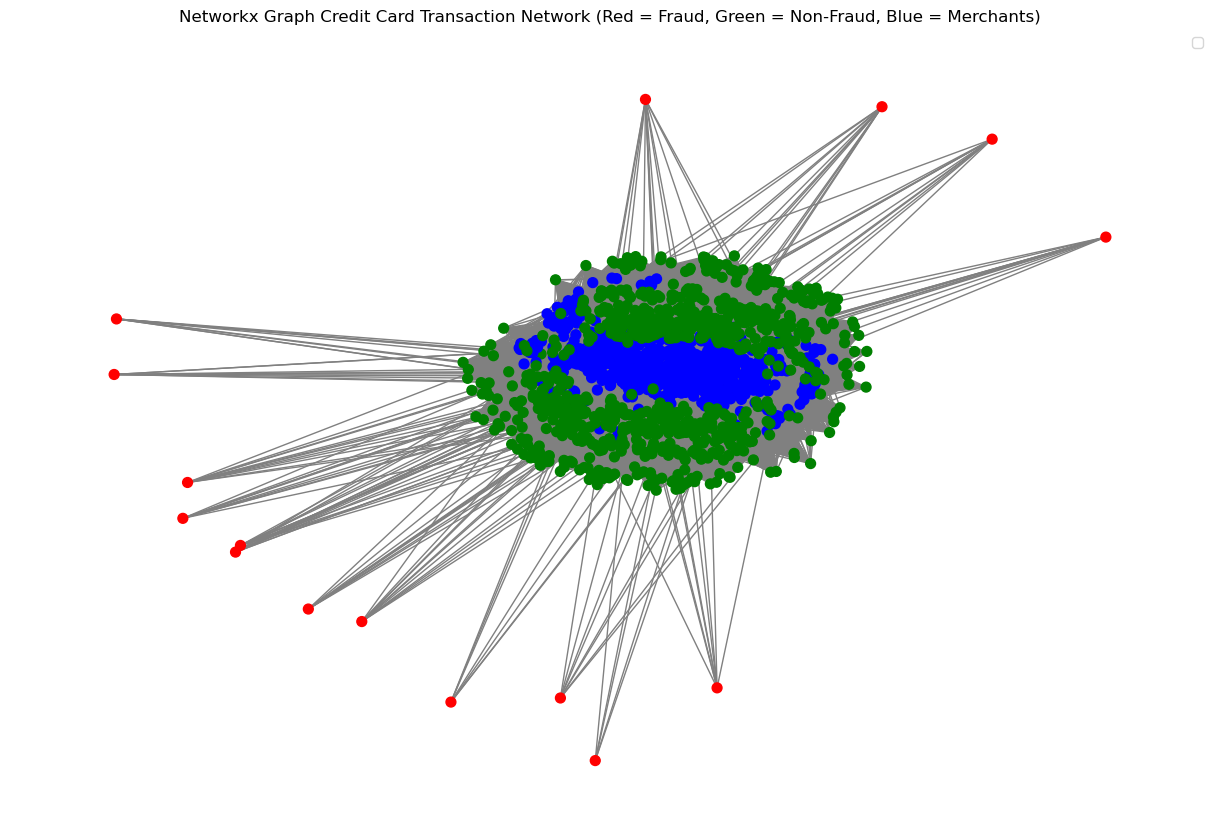

In [205]:
import matplotlib.pyplot as plt
import networkx as nx

# Create positions for nodes using a spring layout (or any other layout)
pos = nx.spring_layout(G)

# Visualize the graph
plt.figure(figsize=(12, 8))

# Create color map based on fraud status (red for fraud, green for non-fraud)
color_map = []
fraud_mapping = df.set_index('CreditCardNumber')['is_fraud'].to_dict()

for node in G.nodes():
    # Check if the node is a customer (CreditCardNumber node) and map fraud status
    if node in fraud_mapping:
        if fraud_mapping[node] == 1:
            color_map.append('red')  # Fraud
        else:
            color_map.append('green')  # Non-fraud
    else:
        # Default color for other nodes (like merchants)
        color_map.append('blue')  # Merchants

# Draw the graph with node colors and edges
nx.draw(G, pos, node_color=color_map, with_labels=False, node_size=50, edge_color='gray')


# Define the title
title = 'Networkx Graph Credit Card Transaction Network (Red = Fraud, Green = Non-Fraud, Blue = Merchants)'
plt.title(title)
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()


/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/718261533.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


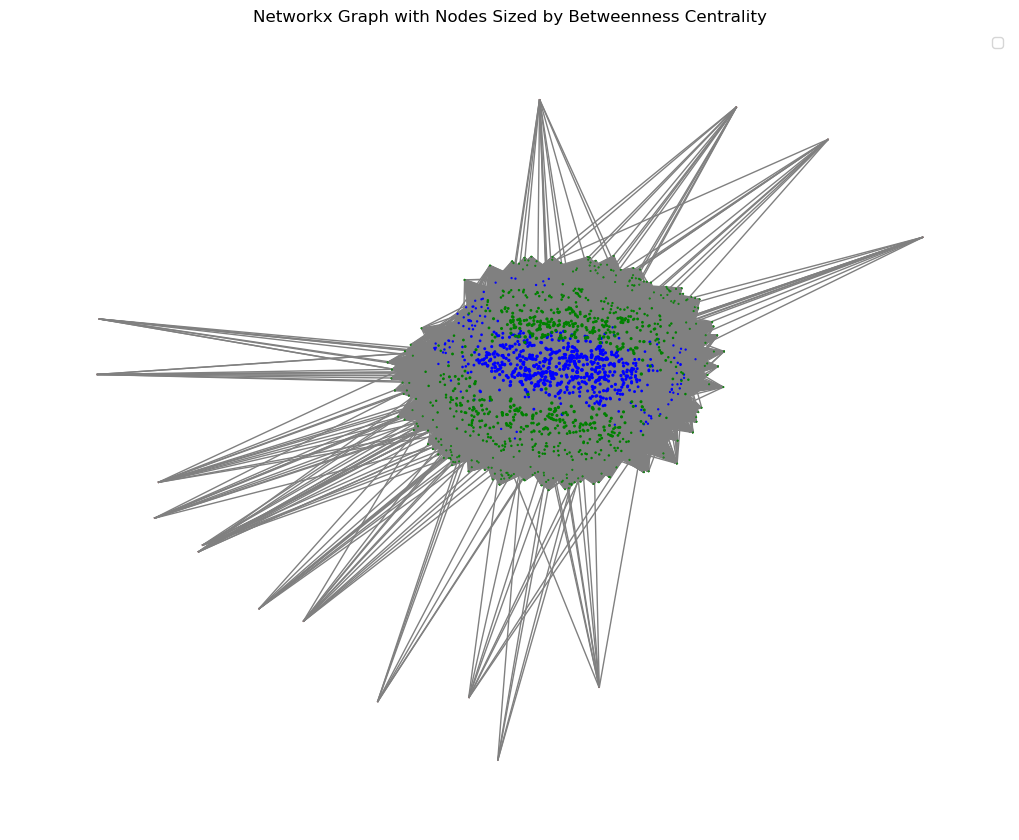

In [206]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Plot graph with nodes sized by betweenness centrality
plt.figure(figsize=(10, 8))
node_size = [v * 2000 for v in betweenness_centrality.values()]  # Scale the node size
nx.draw(G, pos, node_size=node_size, node_color=color_map, with_labels=False, edge_color='gray')

# Define the title
title = 'Networkx Graph with Nodes Sized by Betweenness Centrality'
plt.title(title)
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()



In [207]:

# Map betweenness centrality values to the 'CreditCardNumber' in the DataFrame
df['betweenness_centrality'] = df['CreditCardNumber'].map(betweenness_centrality)


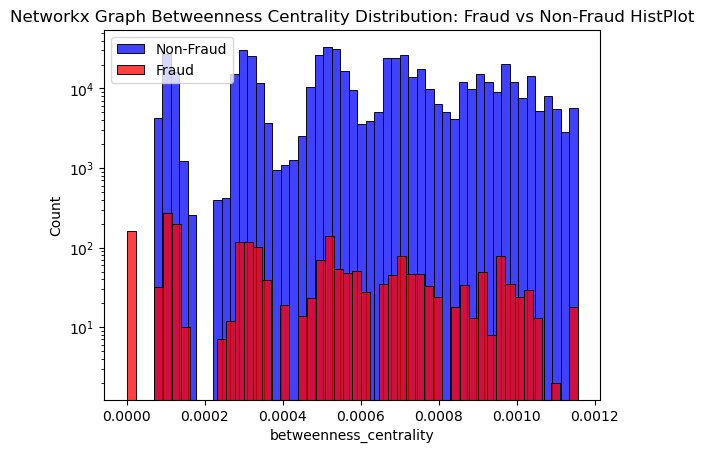

In [208]:


# Plot the betweenness centrality distribution for fraud and non-fraud nodes
sns.histplot(df[df['is_fraud'] == 0]['betweenness_centrality'], bins=50, color='blue', label='Non-Fraud')
sns.histplot(df[df['is_fraud'] == 1]['betweenness_centrality'], bins=50, color='red', label='Fraud')


# Define the title
title = 'Networkx Graph Betweenness Centrality Distribution: Fraud vs Non-Fraud HistPlot'
plt.title(title)
plt.yscale('log')  # Apply log scale to the y-axis
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()


In [209]:
print(df['betweenness_centrality'].describe())
print(df['betweenness_centrality'].isna().sum())  # Check for missing values


count    5.557190e+05
mean     6.166705e-04
std      2.808782e-04
min      6.465593e-08
25%      4.019875e-04
50%      6.335722e-04
75%      8.608403e-04
max      1.156554e-03
Name: betweenness_centrality, dtype: float64
0


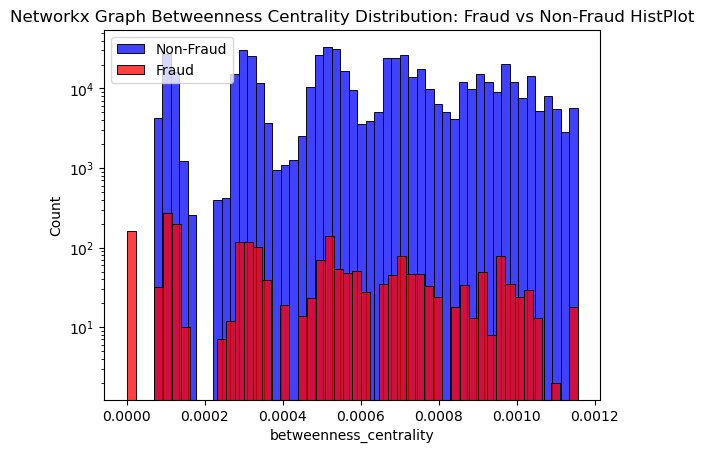

In [210]:
df_filtered = df[df['betweenness_centrality'] > 0]
sns.histplot(df_filtered[df_filtered['is_fraud'] == 0]['betweenness_centrality'], bins=50, color='blue', label='Non-Fraud')
sns.histplot(df_filtered[df_filtered['is_fraud'] == 1]['betweenness_centrality'], bins=50, color='red', label='Fraud')



# Define the title
title = 'Networkx Graph Betweenness Centrality Distribution: Fraud vs Non-Fraud HistPlot'
plt.title(title)
plt.yscale('log')  # Apply log scale to the y-axis
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()


In [211]:
# Check betweenness centrality for specific credit card numbers
sample_nodes = ['60416207185', 'fraud_Kutch-Ferry']  # Replace with actual nodes
for node in sample_nodes:
    print(f"{node}: {betweenness_centrality.get(node)}")


60416207185: 0.0005549149674998762
fraud_Kutch-Ferry: 0.0010695491224161024


1. Investigate Nodes with High Betweenness Centrality:

Now Visualizing nodes with high betweenness centrality:

    Examine if fraudulent nodes tend to have high betweenness centrality. This might indicate that these nodes are acting as "connectors" between different parts of the network, which could be a sign of suspicious behavior.
    Compare centrality between fraud and non-fraud nodes to see if there's a pattern.



2. Visualize Communities in the Network:

You could apply community detection to uncover fraud rings or clusters of merchants targeted by fraudsters. The Louvain algorithm is great for this.

In [212]:
import community.community_louvain as community_louvain


# Apply Louvain method for community detection
partition = community_louvain.best_partition(G)



/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/897508751.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


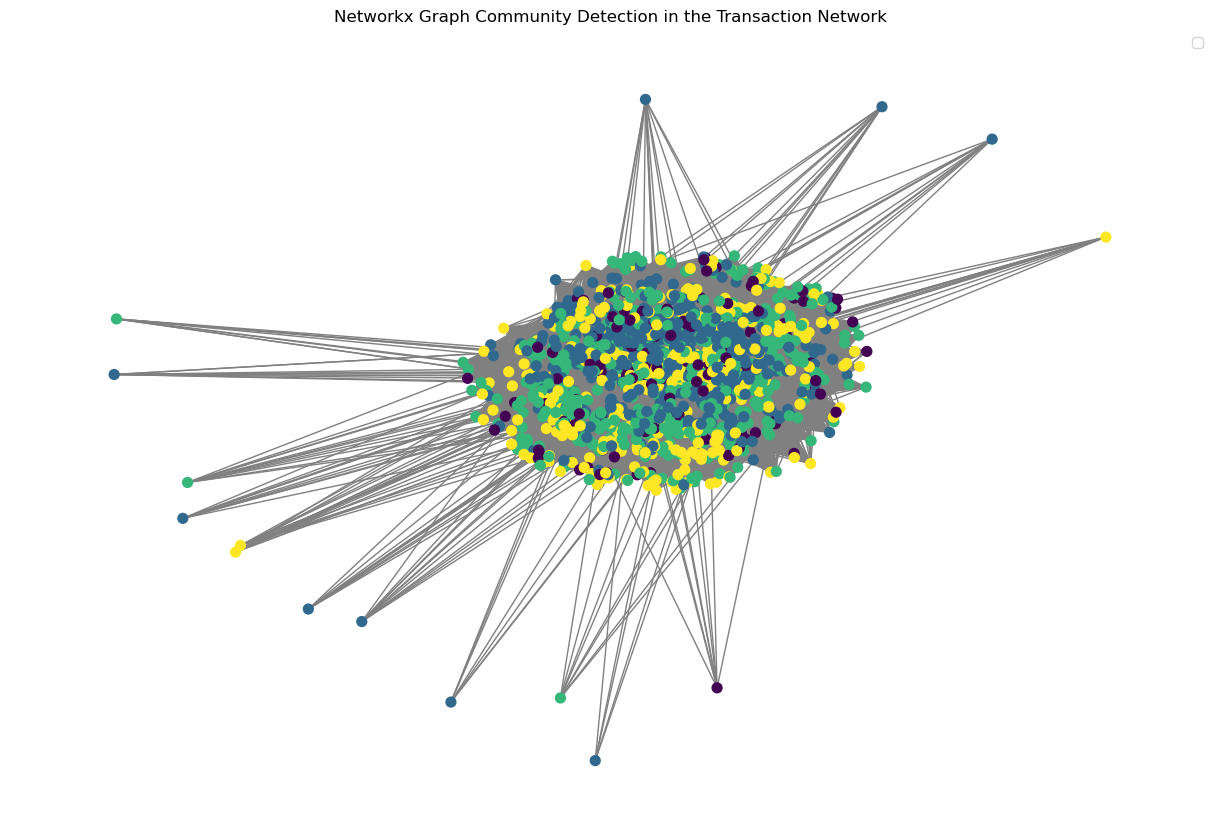

In [213]:
# Visualize communities with node colors representing different communities
plt.figure(figsize=(12, 8))
community_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, node_color=community_colors, with_labels=False, node_size=50, edge_color='gray')

# Define the title
title = 'Networkx Graph Community Detection in the Transaction Network'
plt.title(title)
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

Fraud Node Highlighting:

    Fraudulent nodes (from df['is_fraud'] == 1) are colored red to make them stand out. The rest of the nodes are still colored based on their communities.
    This should help us easily spot any fraudulent nodes in the network.

Top 10 Most Central Nodes:

    Calculate betweenness centrality and extract the top 10 most central nodes.
    These nodes are visualized with their connections, which helps declutter the graph and focus on the key players in the transaction network.

In [214]:

# Apply Louvain method for community detection
partition = community_louvain.best_partition(G)

# Create positions for nodes using a spring layout
pos = nx.spring_layout(G)

# Add the community information to the DataFrame
df['community'] = df['CreditCardNumber'].map(partition)

# Highlight fraud nodes separately
fraud_nodes = df[df['is_fraud'] == 1]['CreditCardNumber'].values




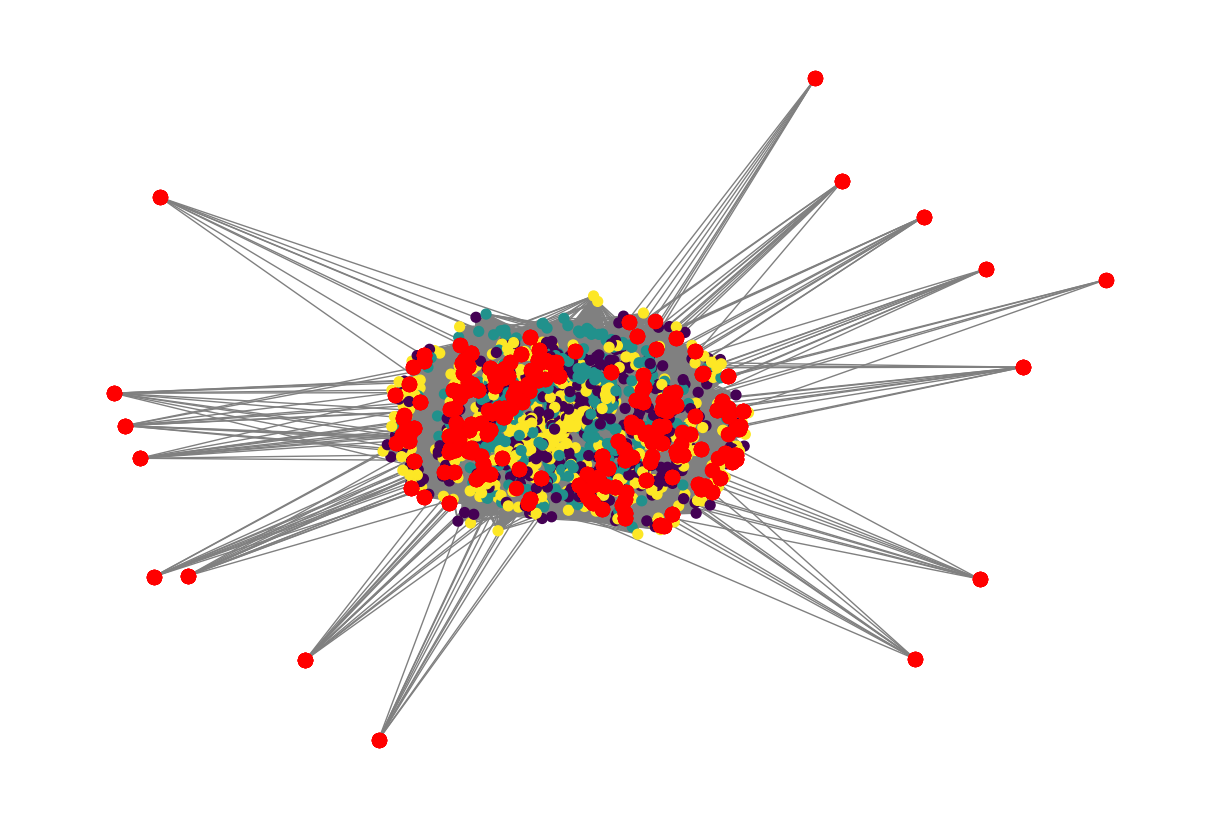

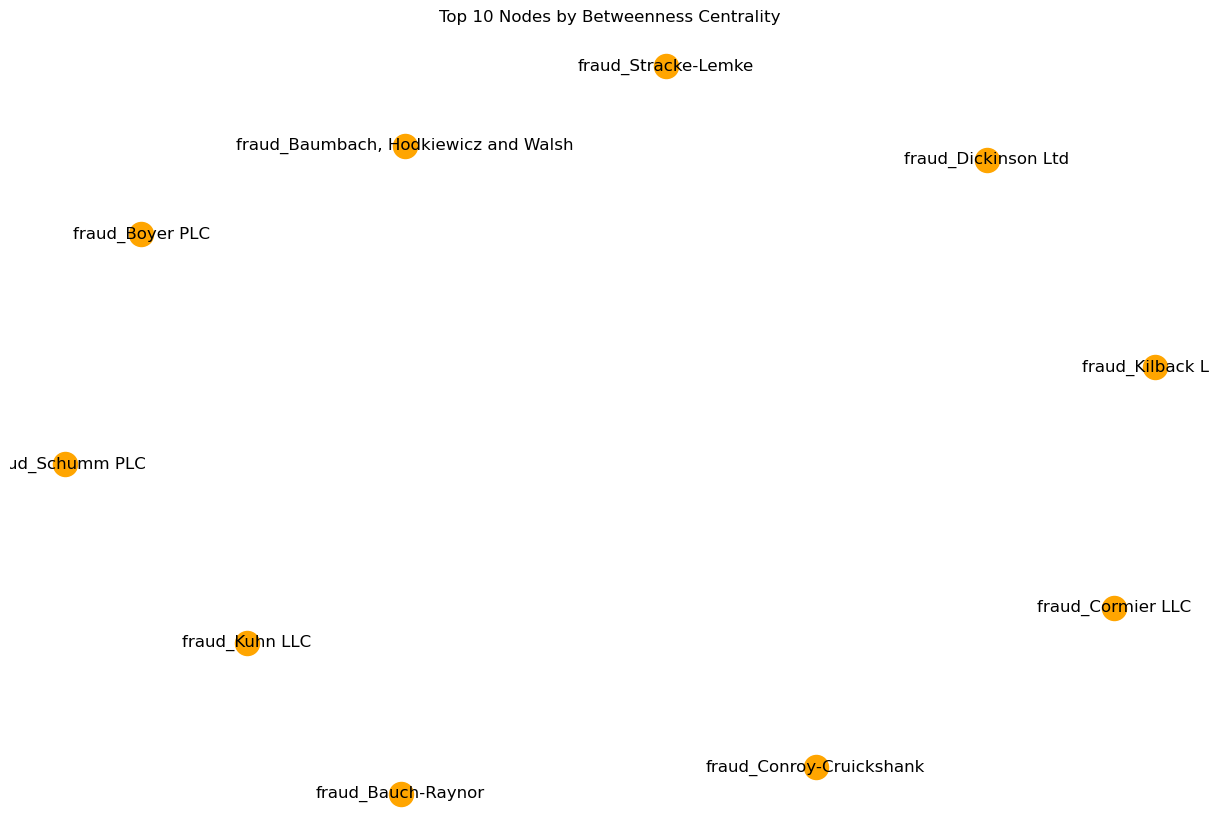

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/2929989961.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


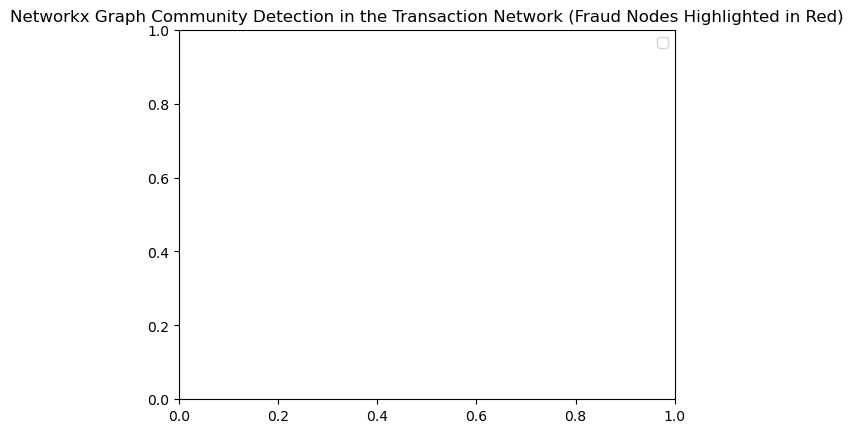

In [215]:
# Visualize communities with node colors representing different communities
plt.figure(figsize=(12, 8))
community_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, node_color=community_colors, with_labels=False, node_size=50, edge_color='gray')

# Highlight fraud nodes in a different color (e.g., red)
nx.draw_networkx_nodes(G, pos, nodelist=fraud_nodes, node_color='red', node_size=100)


# Optional: Visualize Top 10 Nodes by Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
top_10_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:10]

# Visualize only the top 10 most central nodes and their connections
subgraph = G.subgraph(top_10_nodes)
pos_sub = nx.spring_layout(subgraph)

plt.figure(figsize=(12, 8))
nx.draw(subgraph, pos_sub, node_color='orange', with_labels=True, node_size=300, edge_color='gray')
plt.title('Top 10 Nodes by Betweenness Centrality')
plt.show()

# Define the title
title = 'Networkx Graph Community Detection in the Transaction Network (Fraud Nodes Highlighted in Red)'
plt.title(title)
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

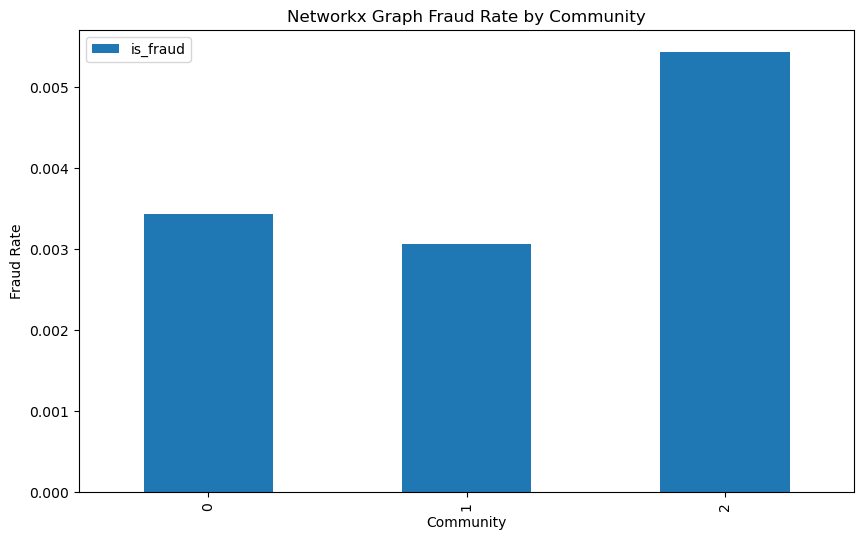

In [216]:
# Add the community information to the DataFrame
df['community'] = df['CreditCardNumber'].map(partition)

# Calculate the percentage of fraud in each community
community_fraud = df.groupby('community')['is_fraud'].mean()

# Plot the fraud rates by community
community_fraud.plot(kind='bar', figsize=(10,6))

# Define the title
title = 'Networkx Graph Fraud Rate by Community'
plt.title(title)
plt.xlabel('Community')
plt.ylabel('Fraud Rate')
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

In [217]:

# Print fraud rate per community
print(community_fraud)


community
0    0.003429
1    0.003066
2    0.005439
Name: is_fraud, dtype: float64


In [218]:
community_size = df.groupby('community').size()
print(community_size)


community
0    183701
1    214273
2    157745
dtype: int64


/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/3755388941.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


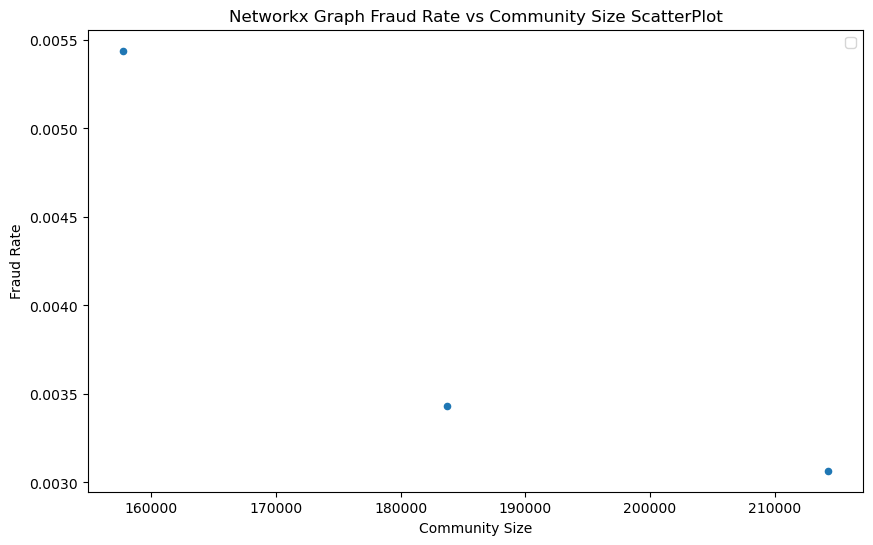

In [219]:
# Combine fraud rates and community sizes into a single DataFrame
fraud_vs_size = pd.concat([community_fraud, df.groupby('community').size()], axis=1)
fraud_vs_size.columns = ['FraudRate', 'CommunitySize']

# Plot Fraud Rate vs Community Size
fraud_vs_size.plot(kind='scatter', x='CommunitySize', y='FraudRate', figsize=(10,6))


# Define the title
title = 'Networkx Graph Fraud Rate vs Community Size ScatterPlot'
plt.title(title)
plt.xlabel('Community Size')
plt.ylabel('Fraud Rate')
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

In [220]:
top_fraud_communities = community_fraud.sort_values(ascending=False).head(5)
print(top_fraud_communities)


community
2    0.005439
0    0.003429
1    0.003066
Name: is_fraud, dtype: float64


In [221]:
# Get the community labels of the top fraud communities
top_community_labels = top_fraud_communities.index.tolist()

# Filter the DataFrame for only the top fraud communities
top_communities_df = df[df['community'].isin(top_community_labels)]


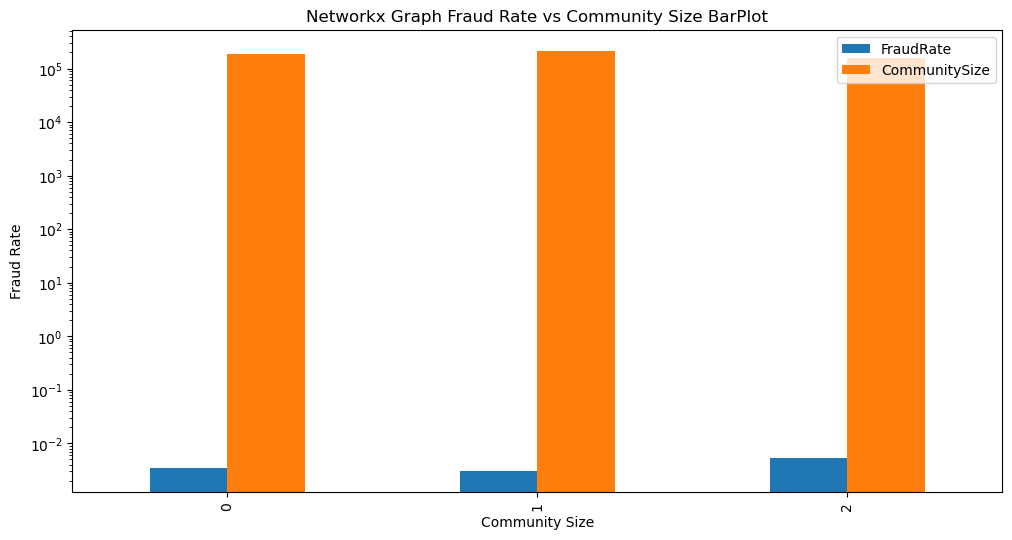

In [222]:
fraud_vs_size.plot(kind='bar', figsize=(12, 6))

# Define the title
title = 'Networkx Graph Fraud Rate vs Community Size BarPlot'
plt.title(title)
plt.xlabel('Community Size')
plt.ylabel('Fraud Rate')
plt.yscale('log')  # Optional, to apply log scale
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

In [223]:
# Show Only the Top Merchants by Fraud Rate:
# Instead of displaying all merchants, you can filter the plot to show only the top 10 or 20 merchants with the highest fraud rates.

# Calculate fraud rate by merchant in the top fraud communities
merchant_fraud_rate = top_communities_df.groupby('merchant')['is_fraud'].mean()

# Sort merchants by fraud rate in descending order
top_merchants = merchant_fraud_rate.sort_values(ascending=False).head(10)

# Print top 10 merchants with highest fraud rate
print(top_merchants)


merchant
fraud_Romaguera, Cruickshank and Greenholt    0.021739
fraud_Lemke-Gutmann                           0.021505
fraud_Mosciski, Ziemann and Farrell           0.020690
fraud_Heathcote, Yost and Kertzmann           0.020482
fraud_Rodriguez, Yost and Jenkins             0.019960
fraud_Medhurst PLC                            0.019430
fraud_Bashirian Group                         0.018987
fraud_Kris-Weimann                            0.018939
fraud_Heathcote LLC                           0.018703
fraud_Bednar Group                            0.018519
Name: is_fraud, dtype: float64


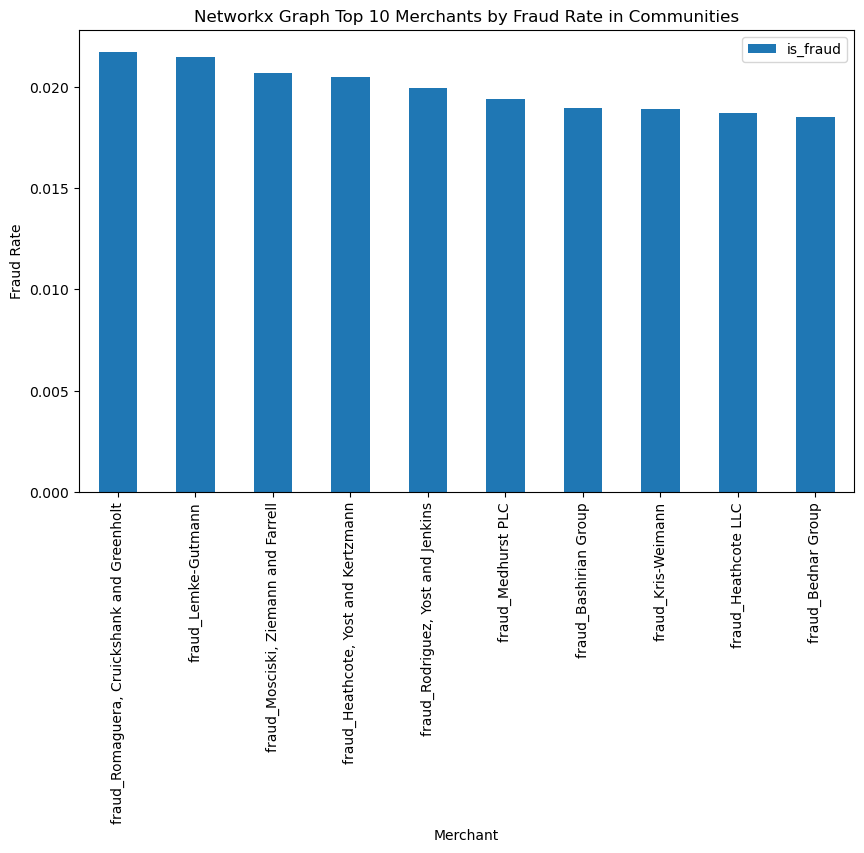

In [224]:
# Show Only the Top Merchants by Fraud Rate:
# Instead of displaying all merchants, you can filter the plot to show only the top 10 or 20 merchants with the highest fraud rates.

# Plot fraud rate for the top 10 merchants
top_merchants.plot(kind='bar', figsize=(10,6))

# Define the title
title = 'Networkx Graph Top 10 Merchants by Fraud Rate in Communities'
plt.title(title)
plt.xlabel('Merchant')
plt.ylabel('Fraud Rate')

plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/1046708900.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


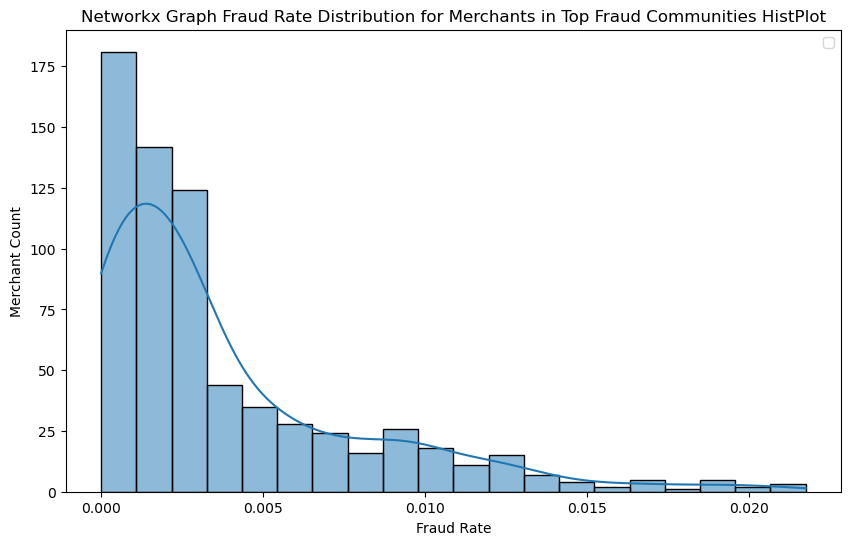

In [225]:
# Plot the distribution of fraud rates for merchants in top fraud communities
plt.figure(figsize=(10,6))

# Plotting fraud rate distribution for merchants
sns.histplot(merchant_fraud_rate, bins=20, kde=True)

# Define the title
title = 'Networkx Graph Fraud Rate Distribution for Merchants in Top Fraud Communities HistPlot'
plt.title(title)
plt.xlabel('Fraud Rate')
plt.ylabel('Merchant Count')

plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

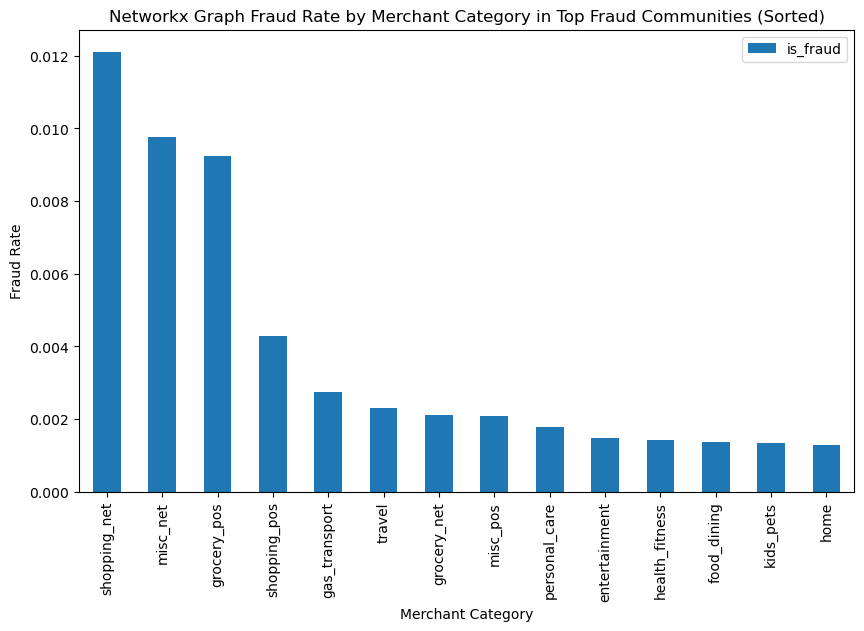

In [226]:

# Assuming 'category' is a column representing merchant categories
merchantcategory_fraud = top_communities_df.groupby('category')['is_fraud'].mean()

# Sort the fraud rate by merchant category in descending order
merchantcategory_fraud_sorted = merchantcategory_fraud.sort_values(ascending=False)

# Plot fraud rate by merchant category (sorted)
merchantcategory_fraud_sorted.plot(kind='bar', figsize=(10,6))

# Define the title
title = 'Networkx Graph Fraud Rate by Merchant Category in Top Fraud Communities (Sorted)'
plt.title(title)
plt.xlabel('Merchant Category')
plt.ylabel('Fraud Rate')
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

In [227]:

# Print the sorted fraud rates
#print(merchantcategory_fraud_sorted)

3. Combine Graph Metrics for Analysis:

Visualized degree and betweenness centrality separately, next to explore combinations of these metrics:

    High betweenness centrality combined with high degree might indicate important fraud hubs.
    Low clustering coefficient with high betweenness could signal isolated fraud nodes acting as key connectors.

Next Calculate clustering coefficient and add it to your analysis:

In [228]:
clustering_coefficient = nx.clustering(G)
df['clustering_coefficient'] = df['CreditCardNumber'].map(clustering_coefficient)


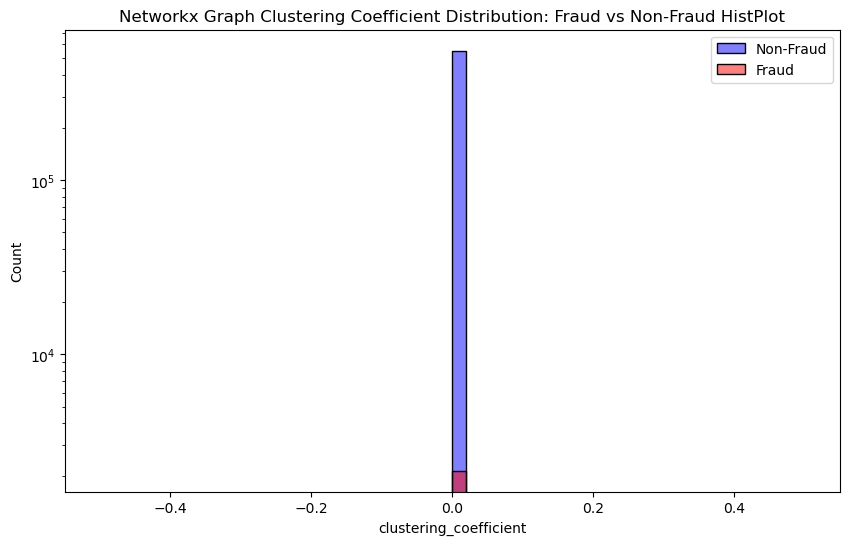

In [229]:

# Visualize the distribution of clustering coefficient for fraud and non-fraud nodes
plt.figure(figsize=(10,6))
sns.histplot(df[df['is_fraud'] == 0]['clustering_coefficient'], bins=50, color='blue', label='Non-Fraud', kde=True)
sns.histplot(df[df['is_fraud'] == 1]['clustering_coefficient'], bins=50, color='red', label='Fraud', kde=True)

# Define the title
title = 'Networkx Graph Clustering Coefficient Distribution: Fraud vs Non-Fraud HistPlot'
plt.title(title)

plt.yscale('log')  # Apply log scale to the y-axis
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()


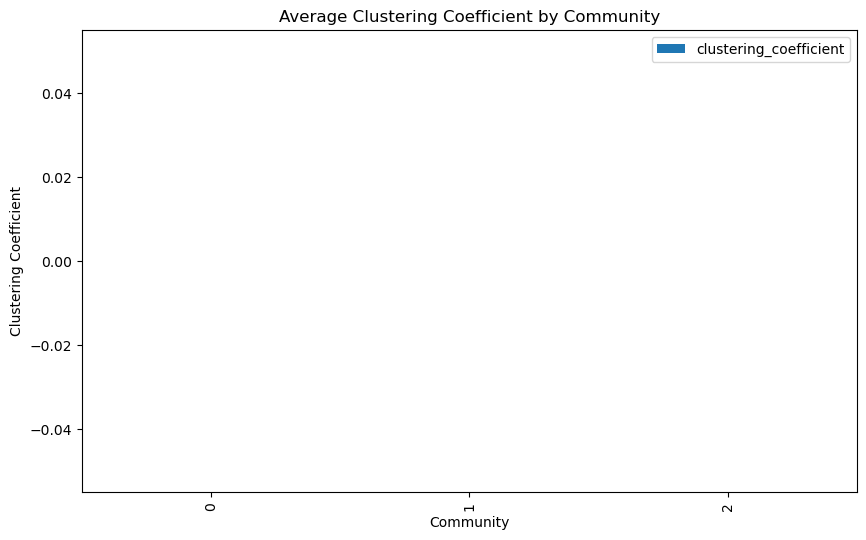

In [230]:
# Compare average clustering coefficient by community
community_clustering = df.groupby('community')['clustering_coefficient'].mean()

# Plot clustering coefficient by community
community_clustering.plot(kind='bar', figsize=(10,6))

# Define the title
title = 'Networkx Graph Average Clustering Coefficient by Community BarPlot'
plt.title(title)

plt.title('Average Clustering Coefficient by Community')
plt.xlabel('Community')
plt.ylabel('Clustering Coefficient')


plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()



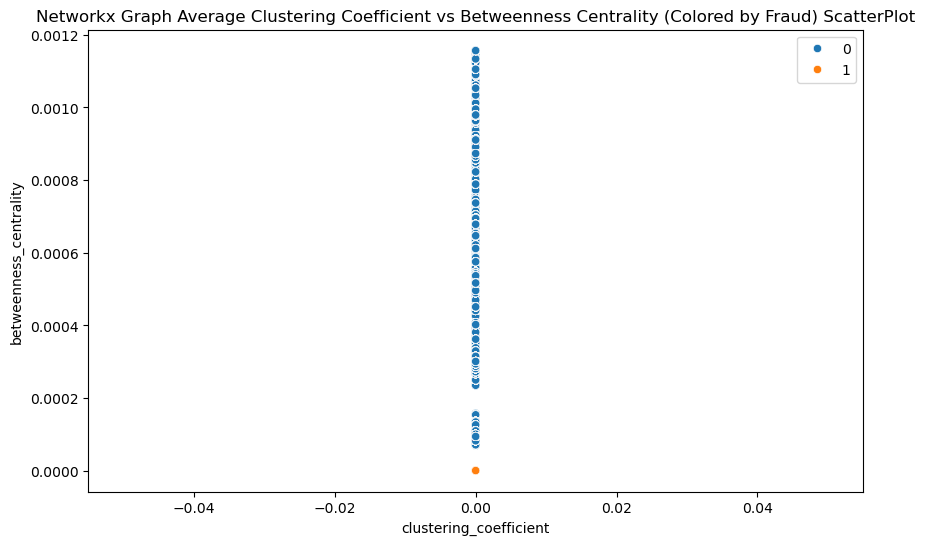

In [231]:
# Scatter plot between clustering coefficient and betweenness centrality
plt.figure(figsize=(10,6))
sns.scatterplot(x='clustering_coefficient', y='betweenness_centrality', hue='is_fraud', data=df)


# Define the title
title = 'Networkx Graph Average Clustering Coefficient vs Betweenness Centrality (Colored by Fraud) ScatterPlot'
plt.title(title)
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()


community
0    0.0
1    0.0
2    0.0
Name: clustering_coefficient, dtype: float64


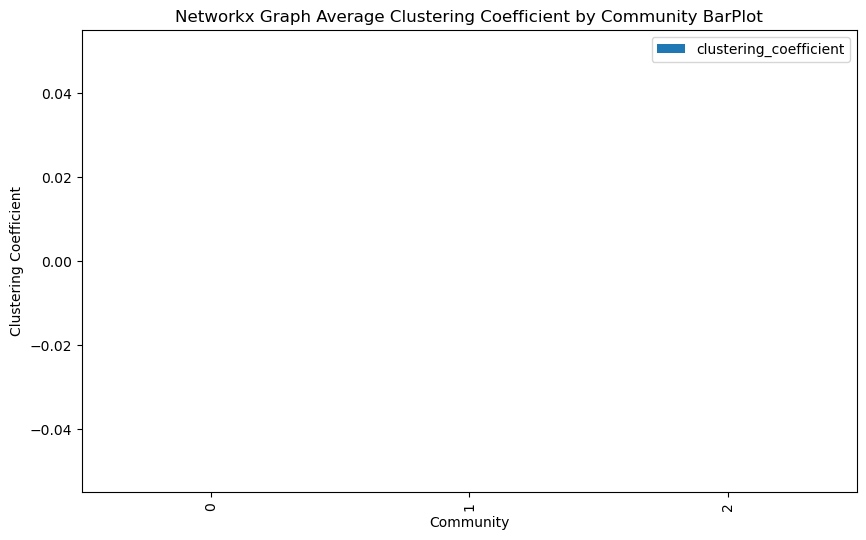

In [232]:
# Check clustering coefficient by community
community_clustering = df.groupby('community')['clustering_coefficient'].mean()

# Print the result to ensure it's not all zeros
print(community_clustering)

# Plot clustering coefficient by community
if not community_clustering.isnull().all():
    community_clustering.plot(kind='bar', figsize=(10,6))

    # Define the title
    title = 'Networkx Graph Average Clustering Coefficient by Community BarPlot'
    plt.xlabel('Community')
    plt.ylabel('Clustering Coefficient')
    plt.title(title)
    plt.legend()

    # Use the title in the filename
    filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
    plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("No clustering coefficients to plot.")


In [233]:
# Check the density of the graph (a measure of sparsity)
density = nx.density(G)
print(f"Graph Density: {density}")


Graph Density: 0.2513486042481799


In [234]:
# Calculate and print the average degree
degree_sequence = [degree for node, degree in G.degree()]
average_degree = sum(degree_sequence) / len(degree_sequence)
print(f"Average Degree of Nodes: {average_degree}")


Average Degree of Nodes: 406.17934446505876


In [235]:
df = df.drop(columns=['clustering_coefficient'])



In [236]:
print(df.columns)

Index(['Unnamed: 0', 'CreditCardNumber', 'merchant', 'category',
       'TransactionAmount', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID', 'Hour', 'HighRiskHour', 'DayOfWeek', 'DayName',
       'IsWeekend', 'distance', 'HighRiskMerchantCategory', 'Age', 'AgeGroup',
       'TransactionFrequency', 'RapidTransactionFlag', 'LogTransactionAmount',
       'HighValueTransactionFlag', 'TransactionCountLast7Days',
       'TransactionCountLast14Days', 'TransactionCountLast30Days',
       'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days', 'degree',
       'betweenness_centrality', 'community'],
      dtype='object')


In [237]:
# Identify top nodes by degree or betweenness centrality
top_degree_nodes = df.nlargest(10, 'degree')
top_betweenness_nodes = df.nlargest(10, 'betweenness_centrality')

# Print top nodes
#print(top_degree_nodes[['CreditCardNumber', 'degree', 'is_fraud']])
#print(top_betweenness_nodes[['CreditCardNumber', 'betweenness_centrality', 'is_fraud']])


Since all the top nodes by degree and betweenness centrality have is_fraud = 0, this suggests that the most connected and central nodes in the network are non-fraudulent. Here are some interpretations and possible next steps:
Interpretation:

    High Connectivity & Centrality Doesn't Mean Fraud:
        The top credit cards or merchants based on degree and betweenness centrality are not fraudulent. This means that having many connections or being central in the network doesn’t necessarily imply fraudulent behavior in this dataset.
        These could be legitimate high-volume merchants or frequent shoppers with many transactions across various merchants.

    Fraudsters May Operate on the Network's Periphery:
        Fraudulent nodes might have lower degree or centrality, potentially indicating that they are more likely to operate in isolated parts of the network rather than being central players.
        Fraud nodes could be attempting to avoid detection by not interacting with too many different entities.

Next Steps:

Since the most central nodes aren't showing fraud, you might want to shift your focus to the nodes with lower centrality or lower degree to see if there’s a different pattern.
1. Analyze Nodes with Lower Degree or Centrality:

You can look at the nodes that have lower degree and lower betweenness centrality and check for fraud among those nodes.

In [238]:
# Identify nodes with the lowest degree or betweenness centrality
bottom_degree_nodes = df.nsmallest(10, 'degree')
bottom_betweenness_nodes = df.nsmallest(10, 'betweenness_centrality')

# Print bottom nodes by degree or betweenness centrality
print(bottom_degree_nodes[['CreditCardNumber', 'degree', 'is_fraud']])
print(bottom_betweenness_nodes[['CreditCardNumber', 'betweenness_centrality', 'is_fraud']])


                        CreditCardNumber  degree  is_fraud
TransactionTime                                           
2020-10-25 06:57:18        4295296907373       5         1
2020-10-25 20:43:20        4295296907373       5         1
2020-10-25 22:34:45        4295296907373       5         1
2020-10-25 22:51:03        4295296907373       5         1
2020-10-25 23:02:32        4295296907373       5         1
2020-10-25 23:32:34        4295296907373       5         1
2020-07-30 00:52:25  4352307151555405069       7         1
2020-07-30 22:07:21  4352307151555405069       7         1
2020-07-30 23:20:10  4352307151555405069       7         1
2020-07-30 23:38:50  4352307151555405069       7         1
                        CreditCardNumber  betweenness_centrality  is_fraud
TransactionTime                                                           
2020-10-25 06:57:18        4295296907373            6.465593e-08         1
2020-10-25 20:43:20        4295296907373            6.465593e-08   

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/2605547893.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


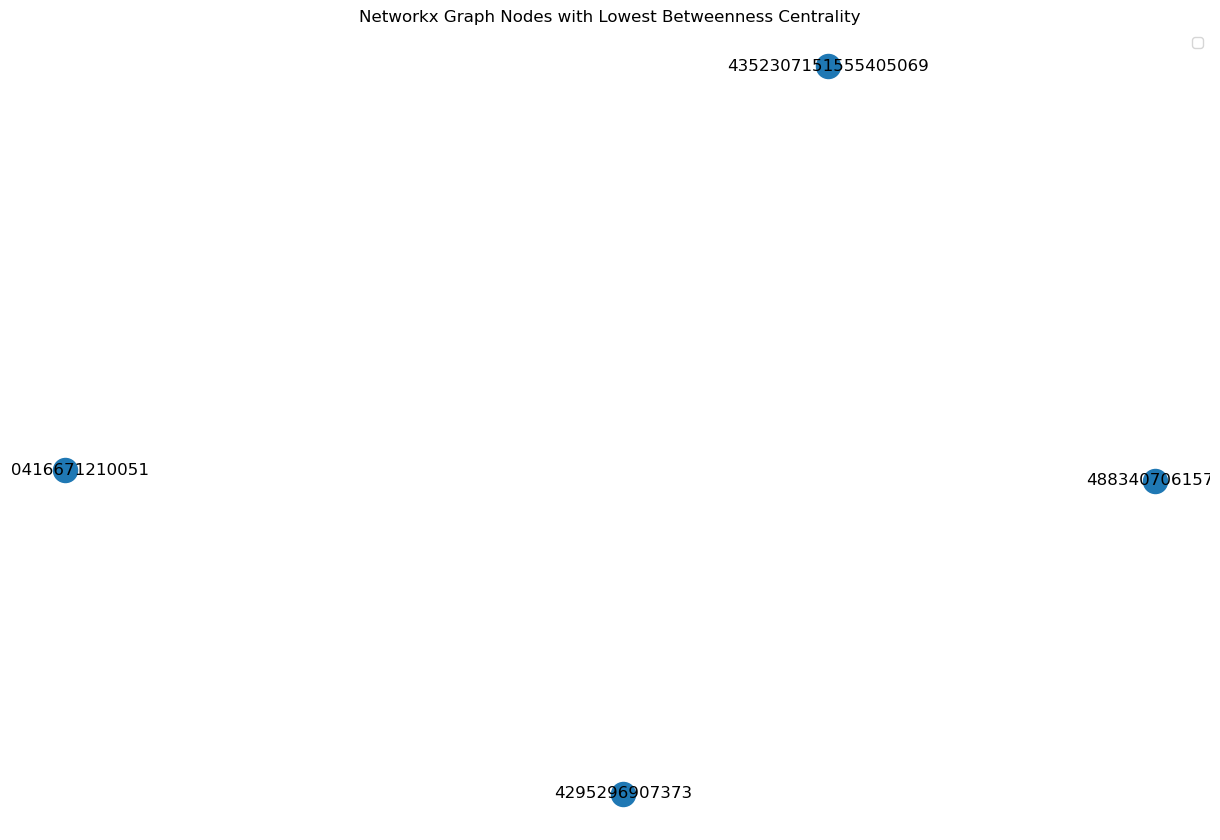

In [239]:
# Identify bottom nodes by betweenness centrality
bottom_betweenness_nodes = df.nsmallest(30, 'betweenness_centrality')['CreditCardNumber']

# Subgraph of nodes with the lowest betweenness centrality
subgraph_low_centrality = G.subgraph(bottom_betweenness_nodes)

# Visualize the subgraph
pos_sub_low = nx.spring_layout(subgraph_low_centrality)
plt.figure(figsize=(12, 8))
nx.draw(subgraph_low_centrality, pos_sub_low, with_labels=True, node_size=300, edge_color='gray')


# Define the title
title = 'Networkx Graph Nodes with Lowest Betweenness Centrality'
plt.title(title)
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()


/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_18776/2742834229.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


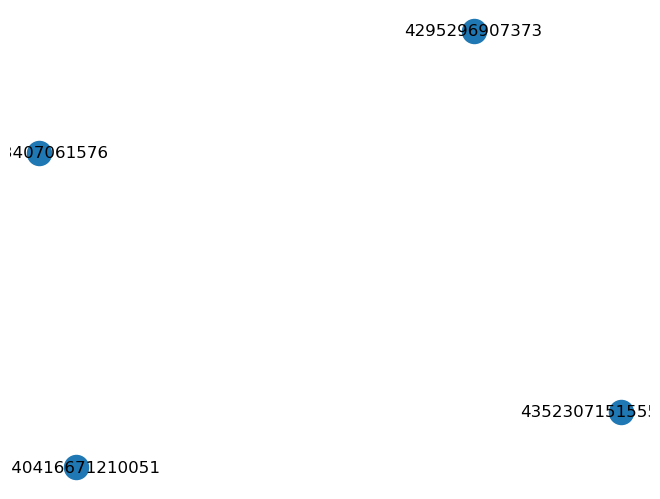

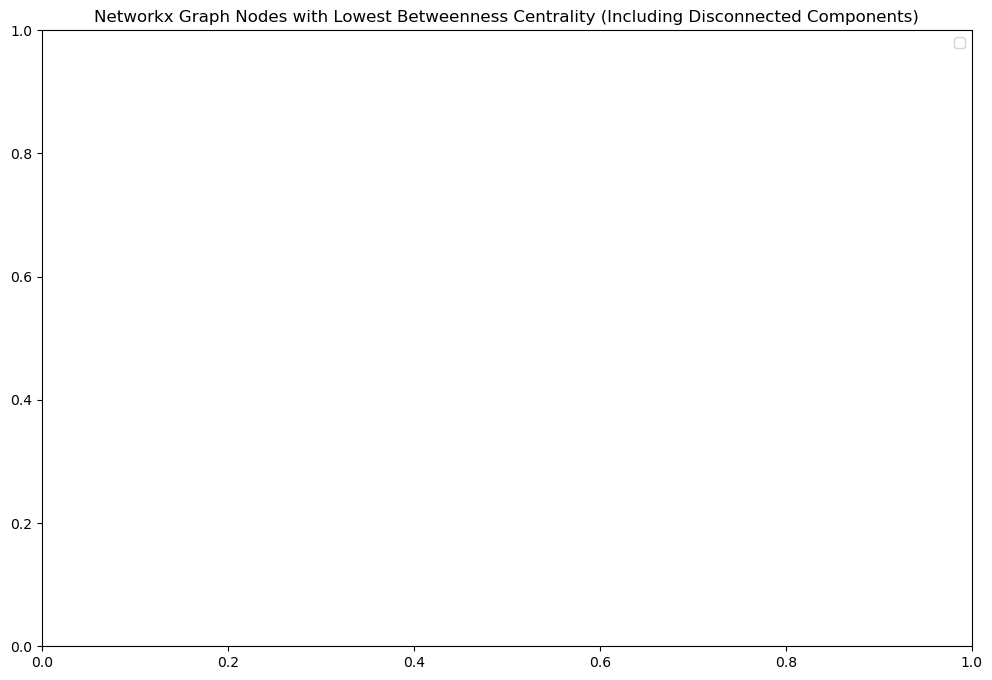

In [240]:
# Visualize the subgraph with disconnected nodes
pos_sub_low = nx.spring_layout(subgraph_low_centrality, k=0.5, iterations=100)
nx.draw(subgraph_low_centrality, pos_sub_low, with_labels=True, node_size=300, edge_color='gray')

plt.figure(figsize=(12, 8))

# Define the title
title = 'Networkx Graph Nodes with Lowest Betweenness Centrality (Including Disconnected Components)'
plt.title(title)
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()

below cell snippets didnt prove to be useful, hence commented out

Why It’s Not Needed Anymore:

    Overcrowded Visualization: When there are too many nodes or connections in a subgraph, the visualization often becomes difficult to interpret. The clutter makes it hard to discern patterns, especially when trying to distinguish fraudulent nodes from non-fraudulent ones.

    Lack of New Insights: Given that already explored degree, betweenness centrality, and community structure, these additional visualizations may not be providing with much new information.

In [241]:
# Print a list of edges with their attributes
#for edge in G.edges(data=True):
#    print(edge)


#test only when issues exisst , output HUGE


In [242]:
selected_features = [
    'TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag',
    'TransactionCountLast7Days', 'TransactionCountLast14Days', 'TransactionCountLast30Days',
    'AverageTransactionAmountLast7Days', 'AverageTransactionAmountLast14Days', 'AverageTransactionAmountLast30Days',
    'Hour', 'HighRiskHour', 'DayOfWeek', 'IsWeekend', 'TransactionFrequency', 'RapidTransactionFlag',
    'lat', 'long', 'merch_lat', 'merch_long', 'distance', 'city_pop',
    'Age', 'AgeGroup', 'gender', 'state', 'city',
    'degree', 'betweenness_centrality', 'community'
]

df_selected_features = df[selected_features]


#     Explore Other Graph Metrics:

        Explore other metrics such as pagerank or eigenvector centrality, which may reveal more about the influence or importance of nodes in the network.

# Page rank as new feature

In [243]:
# Calculate PageRank for each node in the graph
pagerank = nx.pagerank(G)

# Map the PageRank values to the 'CreditCardNumber' in the DataFrame
df['pagerank'] = df['CreditCardNumber'].map(pagerank)


In [244]:
# Check for NaN values in the pagerank column
print(df['pagerank'].isna().sum())


0


In [245]:
# Check descriptive statistics of pagerank values
print(df['pagerank'].describe())



count    555719.000000
mean          0.000636
std           0.000139
min           0.000099
25%           0.000548
50%           0.000669
75%           0.000751
max           0.000850
Name: pagerank, dtype: float64


In [246]:
# Check how many nodes have a PageRank of zero
zero_pagerank_count = (df['pagerank'] == 0).sum()
print(f"Number of nodes with zero PageRank: {zero_pagerank_count}")


Number of nodes with zero PageRank: 0


In [247]:
# Compare the average PageRank for fraud and non-fraud transactions
fraud_avg_pagerank = df[df['is_fraud'] == 1]['pagerank'].mean()
non_fraud_avg_pagerank = df[df['is_fraud'] == 0]['pagerank'].mean()

print(f"Average PageRank for Fraud: {fraud_avg_pagerank}")
print(f"Average PageRank for Non-Fraud: {non_fraud_avg_pagerank}")


Average PageRank for Fraud: 0.0005267197095238786
Average PageRank for Non-Fraud: 0.0006366062405655646


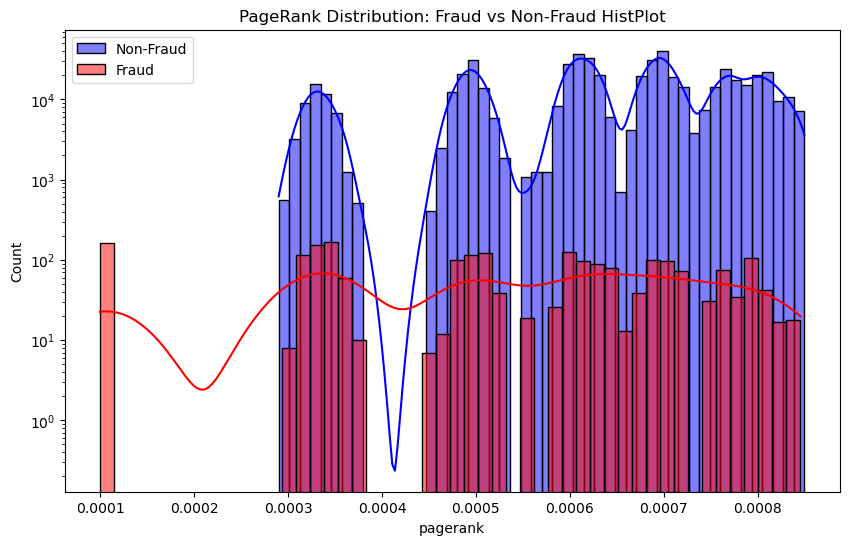

In [248]:
# Visualize the distribution of PageRank for fraud and non-fraud nodes
plt.figure(figsize=(10,6))
sns.histplot(df[df['is_fraud'] == 0]['pagerank'], bins=50, color='blue', label='Non-Fraud', kde=True)
sns.histplot(df[df['is_fraud'] == 1]['pagerank'], bins=50, color='red', label='Fraud', kde=True)


# Define the title
title = 'PageRank Distribution: Fraud vs Non-Fraud HistPlot'
plt.title(title)
plt.legend()
plt.yscale('log')  # Optional: Use log scale if needed

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(output_dir_figures, filename), dpi=300, bbox_inches='tight')
plt.show()


In [249]:
selected_features.append('pagerank')
df_selected_features = df[selected_features]


In [250]:
print(df_selected_features.columns)

Index(['TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag',
       'TransactionCountLast7Days', 'TransactionCountLast14Days',
       'TransactionCountLast30Days', 'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days', 'Hour', 'HighRiskHour',
       'DayOfWeek', 'IsWeekend', 'TransactionFrequency',
       'RapidTransactionFlag', 'lat', 'long', 'merch_lat', 'merch_long',
       'distance', 'city_pop', 'Age', 'AgeGroup', 'gender', 'state', 'city',
       'degree', 'betweenness_centrality', 'community', 'pagerank'],
      dtype='object')


In [251]:
if use_test_data:
    print("Using fraudTest.csv")
else:
    print("Using fraudTrain.csv")


Using fraudTest.csv


In [252]:
print(df.shape)

(555719, 46)


# finalizing anamoloy detection



2. Evaluate Against Fraud Labels:

Let’s now compare the detected anomalies to the actual fraud labels (is_fraud) to see how well the model is flagging fraudulent transactions.

# First round of LogisticRegression

In [253]:
def train_model(df, selected_features):
    # Define target and features
    y = df['is_fraud']
    X = df[selected_features]

    # One-hot encode fraudTrain data
    X_encoded = pd.get_dummies(X, drop_first=True)
    fraudTrain_columns = X_encoded.columns

    # Save fraudTrain_columns
    fraudTrain_columns_df = pd.DataFrame(fraudTrain_columns)
    data_processed_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/data/processed'
    fraudTrain_columns_df.to_csv(os.path.join(data_processed_dir, 'fraudTrain_columns.csv'), index=False)

    # Impute missing values and train the model
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X_encoded)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_imputed, y)

    # Make predictions on the training set
    y_pred_train = model.predict(X_imputed)

    # Generate the classification report
    report_train = classification_report(y, y_pred_train)


    # Return the report, model, and imputer
    return report_train, model, imputer



In [254]:
def evaluate_model(df, selected_features, model, imputer):
    # Load fraudTrain_columns
    data_processed_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/data/processed'
    fraudTrain_columns = pd.read_csv(os.path.join(data_processed_dir, 'fraudTrain_columns.csv')).squeeze()

    # Define features for fraudTest
    X_fraudTest = df[selected_features]
    X_encoded_fraudTest = pd.get_dummies(X_fraudTest, drop_first=True)
    X_encoded_fraudTest = X_encoded_fraudTest.reindex(columns=fraudTrain_columns, fill_value=0)

    # Impute missing values for fraudTest
    X_imputed_fraudTest = imputer.transform(X_encoded_fraudTest)

    # Use the trained model to make predictions on fraudTest
    y_pred_fraudTest = model.predict(X_imputed_fraudTest)

    # Correct target labels for fraudTest
    y_test = df['is_fraud']

    # Generate the classification report
    report_Test = classification_report(y_test, y_pred_fraudTest)

    # Return the report, model, and imputer
    return report_Test, model, imputer




In [255]:
# Start timer
import time
start_time = time.time()


In [256]:
import pickle
import os
from sklearn.metrics import classification_report
import pandas as pd

# Main control flow based on use_test flag
if not use_test_data:
    # Call train_model function for fraudTrain.csv and get the classification report, model, and imputer
    report_train, model, imputer = train_model(df, selected_features)
    print(report_train)
    report = report_train
else:
    # Call evaluate_model function for fraudTest.csv and get the classification report, model, and imputer
    report_Test, model, imputer = evaluate_model(df, selected_features, model, imputer)
    print(report_Test)
    report = report_Test

# Specify the output directory for the report
reports_output_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports'

# Ensure the directory exists
if not os.path.exists(reports_output_dir):
    os.makedirs(reports_output_dir)

# Create a dynamic filename for the classification report
dataset_type = 'Train' if not use_test_data else 'Test'  # Dynamic based on whether it's train or test
classification_report_title = 'Logistic Regression Classification Report'
classification_report_outputfilename = f"{dataset_type}_{classification_report_title.replace(' ', '_').replace(',', '').lower()}.txt"

# Save the classification report to a text file
with open(os.path.join(reports_output_dir, classification_report_outputfilename), 'w') as f:
    f.write(report)  # Writing the classification report string to the file

print(f"Classification report saved to: {os.path.join(reports_output_dir, classification_report_outputfilename)}")

# Specify the output directory for saving the model
output_dir_model = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/models'

# Create a dynamic filename for the model
model_title = 'Logistic Regression Credit Fraud Detection Model'
outputfilename_model = f"{dataset_type}_{model_title.replace(' ', '_').replace(',', '').lower()}.pkl"

# Save the model as a pickle file
with open(os.path.join(output_dir_model, outputfilename_model), 'wb') as model_file:
    pickle.dump(model, model_file)

print(f"Model saved to: {os.path.join(output_dir_model, outputfilename_model)}")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.46      0.38      0.41      2145

    accuracy                           1.00    555719
   macro avg       0.73      0.69      0.71    555719
weighted avg       1.00      1.00      1.00    555719

Classification report saved to: /Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/Test_logistic_regression_classification_report.txt
Model saved to: /Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/models/Test_logistic_regression_credit_fraud_detection_model.pkl


In [257]:
# End timer
end_time = time.time()
print(f"Time taken to run the model: {end_time - start_time:.2f} seconds")


Time taken to run the model: 52.31 seconds
